# Performing combined approximation and continuity optimization target experiments

In this Jupyter notebook we repeat the baseline experiments in the combined $C^k$- and approximation loss optimization setting. 

Version 2.0
Date: 2024-01-15
Current version: hannes.waclawek@fh-salzburg.ac.at

In [152]:
import copy

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# How is convergence influenced?

## General

Continuity optimization works and results converge.

## Alpha

We increase alpha with rising variance as more emphasis on continuity optimization is required.  
The next notebooks will take a closer look into the alpha parameter.  
For this one we use:  
- Simple rise: 0.1
- Sine: 0.1
- Sine with varying frequency: 0.6
- Noisy Sine with varying frequency: 0.999

## Learning rate and number of epochs  
 
Contrary to the single approximation target of the previous Jupyter notebook, 
here we see that a lower learning rate of 0.1 is beneficial.
Also contrary to the single approximation target, the combined C^k and approximation goal now leads to a non-convex loss landscape
and we see spikes in the loss curve at some epoch ranges. This is expected, if optimization leaves a local optima towards a lower optimum.
Early stopping and reverting to the best loss / coefficients of the training cycle can prevent ending up with an unsatisfiable local optimum result.

**A learning rate of 0.1 seems to be a reasonable choice for all bases.**
**2000 epochs seem to be sufficient. With early stopping we can have less.**
  
## Number of polynomials
  
Raising the number of polynomials, as expected, reduces remaining losses and, for Chebyshev basis, shows less spikes in remaining losses.
If we increase the number of segments, the variance in the individual segments input data is effectively decreased.  
A learning rate of 0.1 still is good for more polynomials. 

## Optimizers  
  
Chebyshev basis is clearly outperforming Power Basis in regard to all observed optimizers and input point sets.
**None of the optimizers manage to surpass the l2 optimum with Power basis in the given 5000 epochs for the lowest variance input data (name in this notebook: Simple rise curve).**
**There are, however, several optimizers that achieve this with Chebyshev basis.**
The more variance is in the input data, the higher is the loss for the l2 baseline with CK loss.
The more variance is in the input data, the more optimizers (also with Power basis) manage to surpass this l2 baseline.
The following optimizer candidates surpass the l2 baseline with all observed input data:
1. adam, amsgrad
2. adamax
3. adagrad, ftrl
4. nadam

Considering all observed input data, Adam AMSGrad is the best candidate.
With least squares fit initialization of polynomial coefficients, Power basis gets competitive again.
However, Chebyshev basis with AMSGrad still shows the best convergence behaviour also in that scenario.

## AMSGrad optimizer parameters

Default parameters perform best for Power and Chebyshev basis.

## $C^k$ loss regularization

Results with $C^k$ loss regularization outperform results without $C^k$ loss regularization for all candidate optimizers.
The more variance is in the input data, the closer is the gap. 


## Data


Text(0.5, 1.0, 'Scaled to range [0, 2] for 2 polynomial segments')

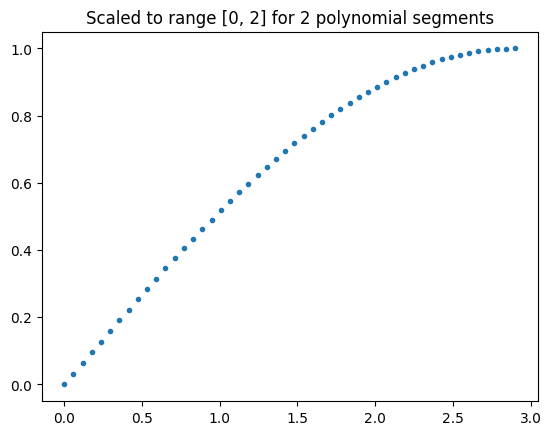

In [154]:
# The data set to approximate with x and y samples
xs2_ori = np.linspace(0, 0.5*np.pi, 50)
ys2 = np.sin(xs2_ori)
#plt.plot(xs2_ori, ys2, '.')
xs2 = sampledata.rescale_input_data(xs2_ori, 2.9)
plt.plot(xs2, ys2, '.')
plt.title('Scaled to range [0, 2] for 2 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 4] for 4 polynomial segments')

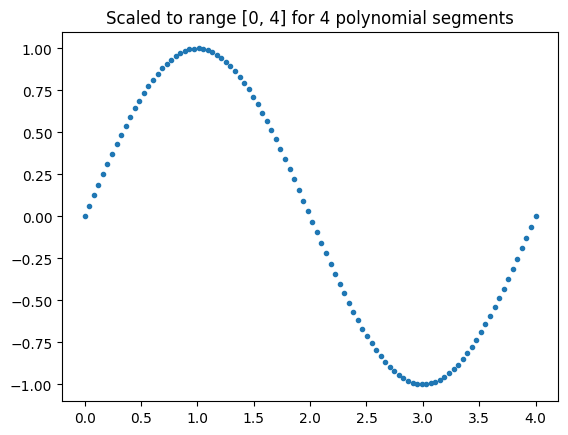

In [155]:
xsin = np.linspace(0, 2*np.pi, 100)
ysin = np.sin(xsin)
xsin = sampledata.rescale_input_data(xsin, 4)

plt.plot(xsin, ysin, '.')
plt.title('Scaled to range [0, 4] for 4 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 10] for 10 polynomial segments')

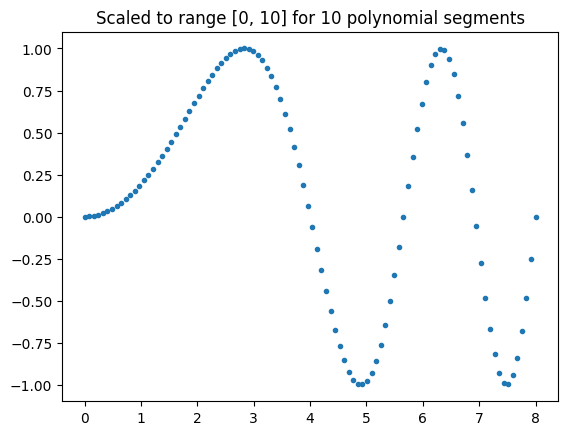

In [156]:
xsinvar = np.linspace(0, 1, 100)
ysinvar = np.sin(xsinvar**2 * 4 * np.pi)
xsinvar = sampledata.rescale_input_data(xsinvar, 8)

plt.plot(xsinvar, ysinvar, '.')
plt.title('Scaled to range [0, 10] for 10 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 2] for 2 polynomial segments')

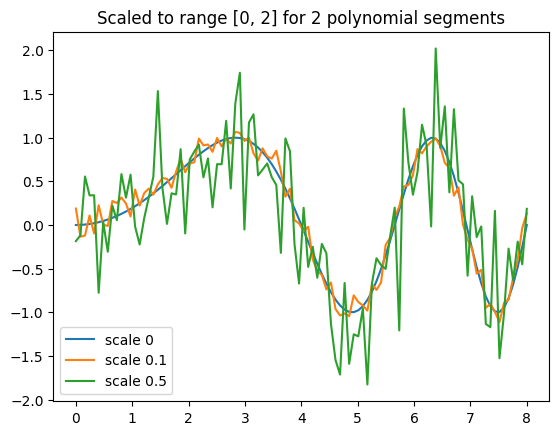

In [157]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ys2gauss_scales = [0.0, 0.1, 0.5]
ys2gauss = [ysinvar + np.random.normal(scale=s, size=len(ysinvar)) for s in ys2gauss_scales]

for i, ysn in enumerate(ys2gauss):
    plt.plot(xsinvar, ysn, '-', label='scale %.2g' % ys2gauss_scales[i])
plt.legend(loc="best")
plt.title('Scaled to range [0, 2] for 2 polynomial segments')

## Parameters

In [158]:
ck = 3
degree = 7
alpha3 = 0.9990
alpha2 = 0.6
alpha = 0.1
learning_rate = 0.1

colors = list(mcolors.TABLEAU_COLORS.keys())

## Investigating epochs and learning rates

In [159]:
no_segments = 2
data_x = xsin
data_y = ysin
factor_approximation_quality = 1 - alpha
factor_ck_pressure = alpha
epochs = 2000
epoch_steps = [100, 500, 1000, 1999]
lrs = [10.0**e for e in np.arange(-2.0, 1.25, 0.25)]

In [26]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'optimizer': 'AMSGrad', 'mode': 'learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'optimizer': 'AMSGrad' , 'mode': 'learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]

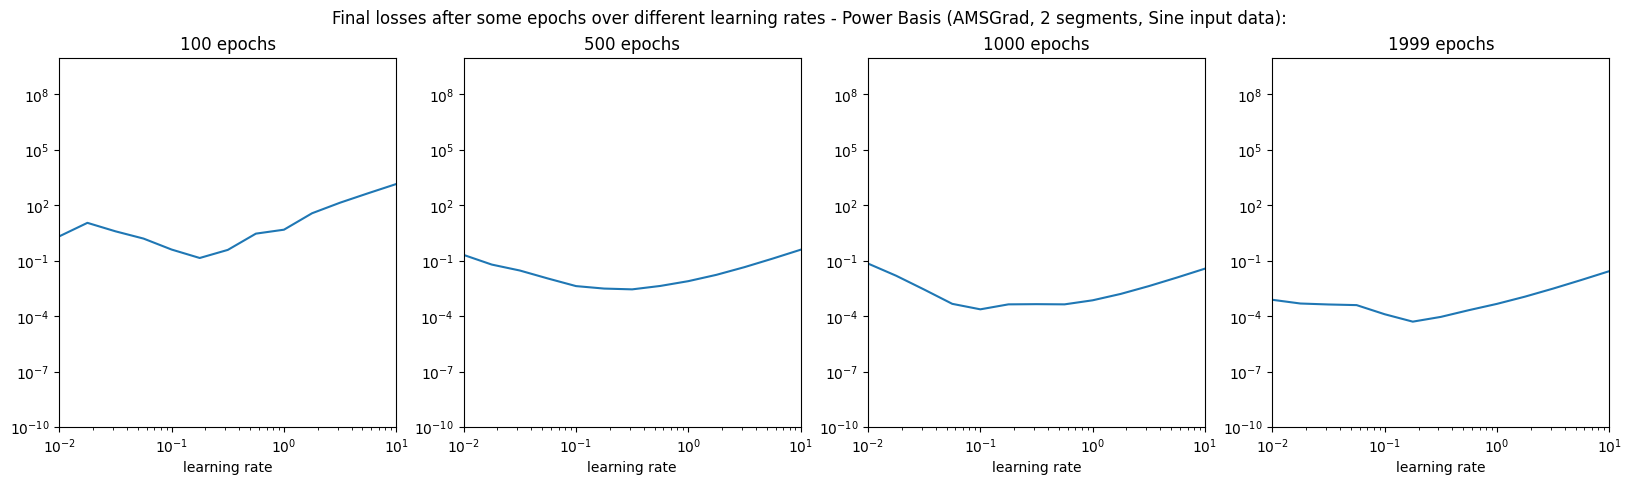

In [27]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Power Basis (AMSGrad, {no_segments} segments, Sine input data):")

for i, epoch in enumerate(epoch_steps):
    ax = axes[i]
    
    ax.set_title("%d epochs" % epoch)
    
    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epoch] for row in losses])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-10, 1e10])

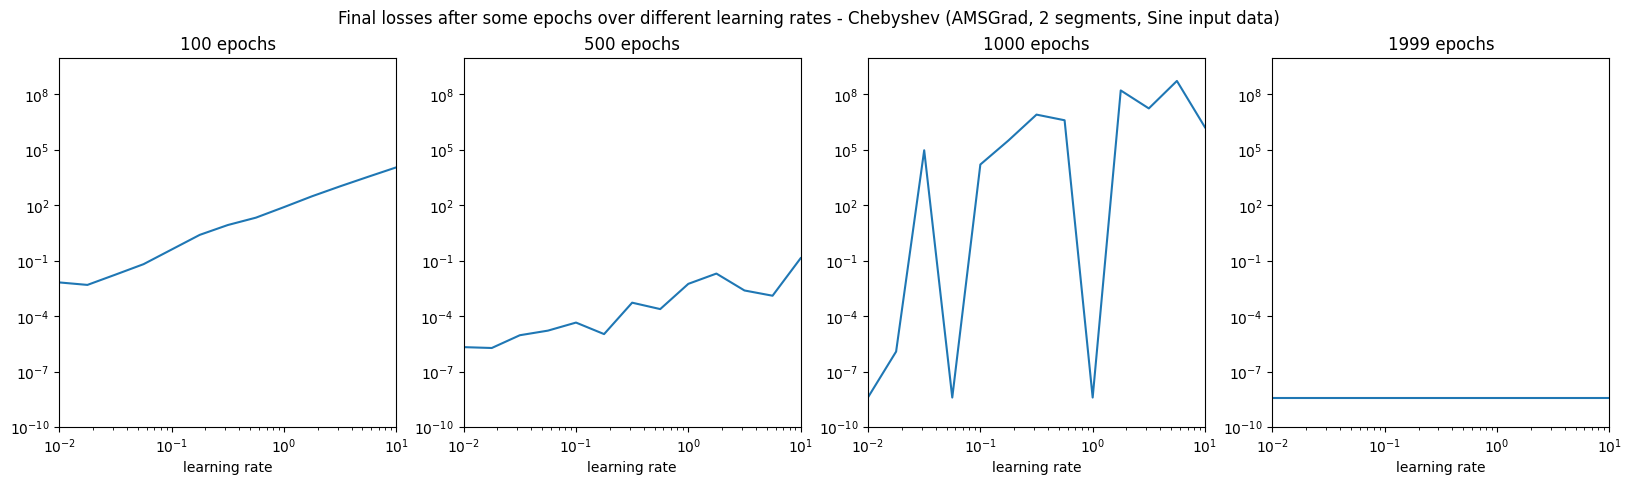

In [28]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Chebyshev (AMSGrad, {no_segments} segments, Sine input data)")

for i, epoch in enumerate(epoch_steps):
    ax = axes[i]

    ax.set_title("%d epochs" % epoch)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epoch] for row in losses_chebyshev])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-10, 1e10])

## Interpretation

Contrary to the single approximation target of the previous Jupyter notebook, 
here we see that a lower learning rate of 0.1 is beneficial.
Also contrary to the single approximation target, the combined C^k and approximation goal now leads to a non-convex loss landscape
and we see spikes in the loss curve at some epoch ranges. This is expected, if optimization leaves a local optima towards a lower optimum.
Early stopping and reverting to the best loss / coefficients of the training cycle can prevent ending up with an unsatisfiable local optimum result.

**A learning rate of 0.1 seems to be a reasonable choice for all bases.**
**2000 epochs seem to be sufficient. With early stopping we can have less.**

## Investigating number of polynomials

In [160]:
no_segments = 4

In [161]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'optimizer': 'AMSGrad', 'mode': 'learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'optimizer': 'AMSGrad' , 'mode': 'learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]

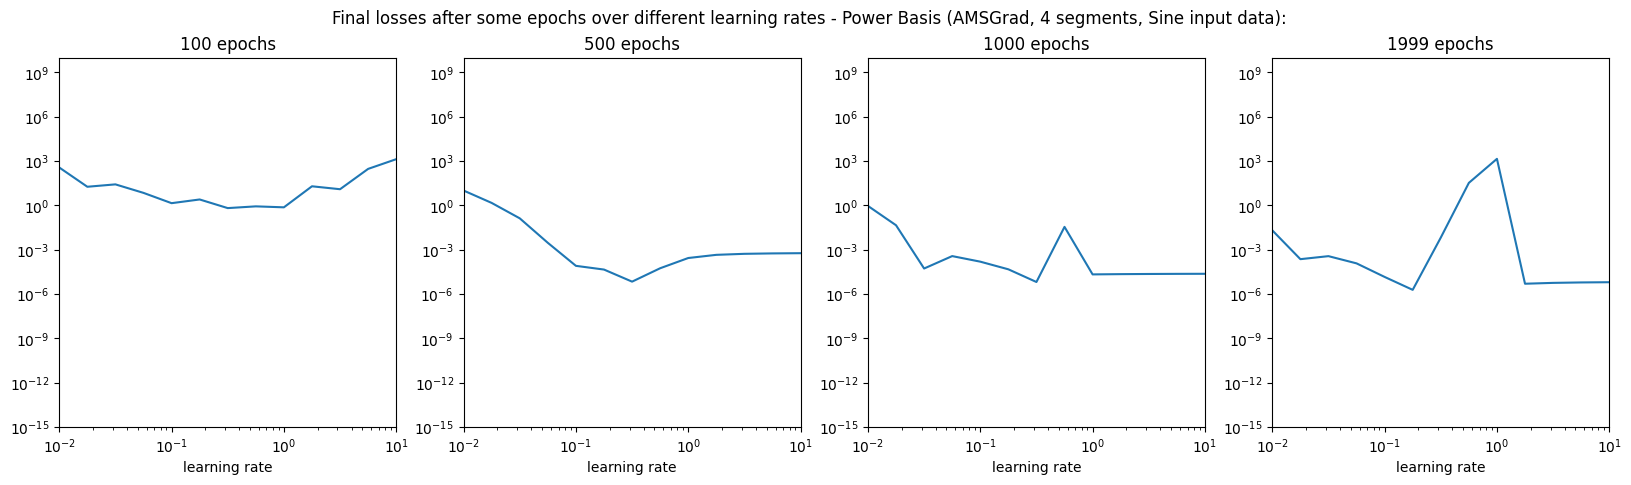

In [162]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Power Basis (AMSGrad, {no_segments} segments, Sine input data):")

for i, epoch in enumerate(epoch_steps):
    ax = axes[i]
    
    ax.set_title("%d epochs" % epoch)
    
    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epoch] for row in losses])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-15, 1e10])

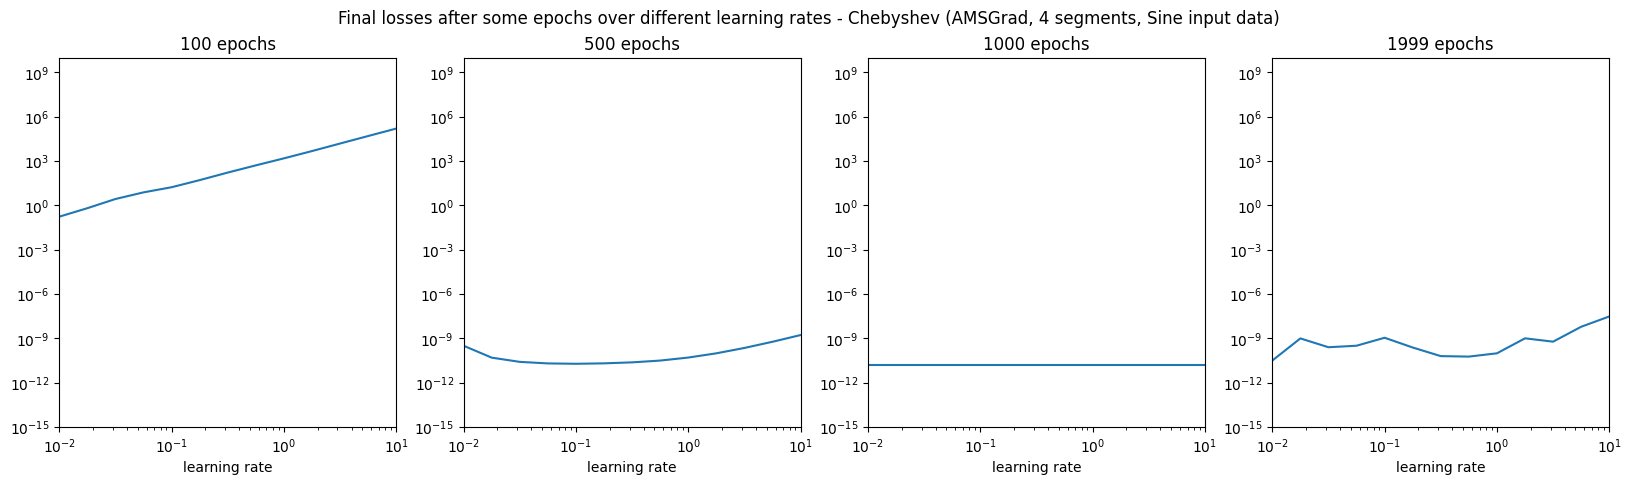

In [163]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Chebyshev (AMSGrad, {no_segments} segments, Sine input data)")

for i, epoch in enumerate(epoch_steps):
    ax = axes[i]

    ax.set_title("%d epochs" % epoch)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epoch] for row in losses_chebyshev])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-15, 1e10])

## Interpretation

Raising the number of polynomials, as expected, reduces remaining losses and, for Chebyshev basis, shows less spikes in remaining losses.
A learning rate of 0.1 still is a good choice.

# Investigating optimizers 

In [94]:
optimizers = ['sgd', 'sgd-momentum', 'sgd-momentum-nesterov', 'adagrad', 'adadelta', 'rmsprop', 'adam', 'adamax', 'nadam', 'adam-amsgrad', 'adafactor', 'adamw', 'ftrl', 'lion']
epochs = 5000

## Simple rise - 2 polynomials

In [100]:
no_segments = 2
data_x = xs2
data_y = ys2
factor_approximation_quality = 1 - alpha
factor_ck_pressure = alpha

In [40]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [41]:
losses_with_1 = copy.deepcopy(losses_with)
%store losses_with_1
losses_without_1 = copy.deepcopy(losses_without)
%store losses_without_1
losses_chebyshev_with_1 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_1
losses_chebyshev_without_1 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_1

Stored 'losses_with_1' (list)
Stored 'losses_without_1' (list)
Stored 'losses_chebyshev_with_1' (list)
Stored 'losses_chebyshev_without_1' (list)


In [42]:
%store -r losses_with_1
%store -r losses_without_1
%store -r losses_chebyshev_with_1
%store -r losses_chebyshev_without_1

C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


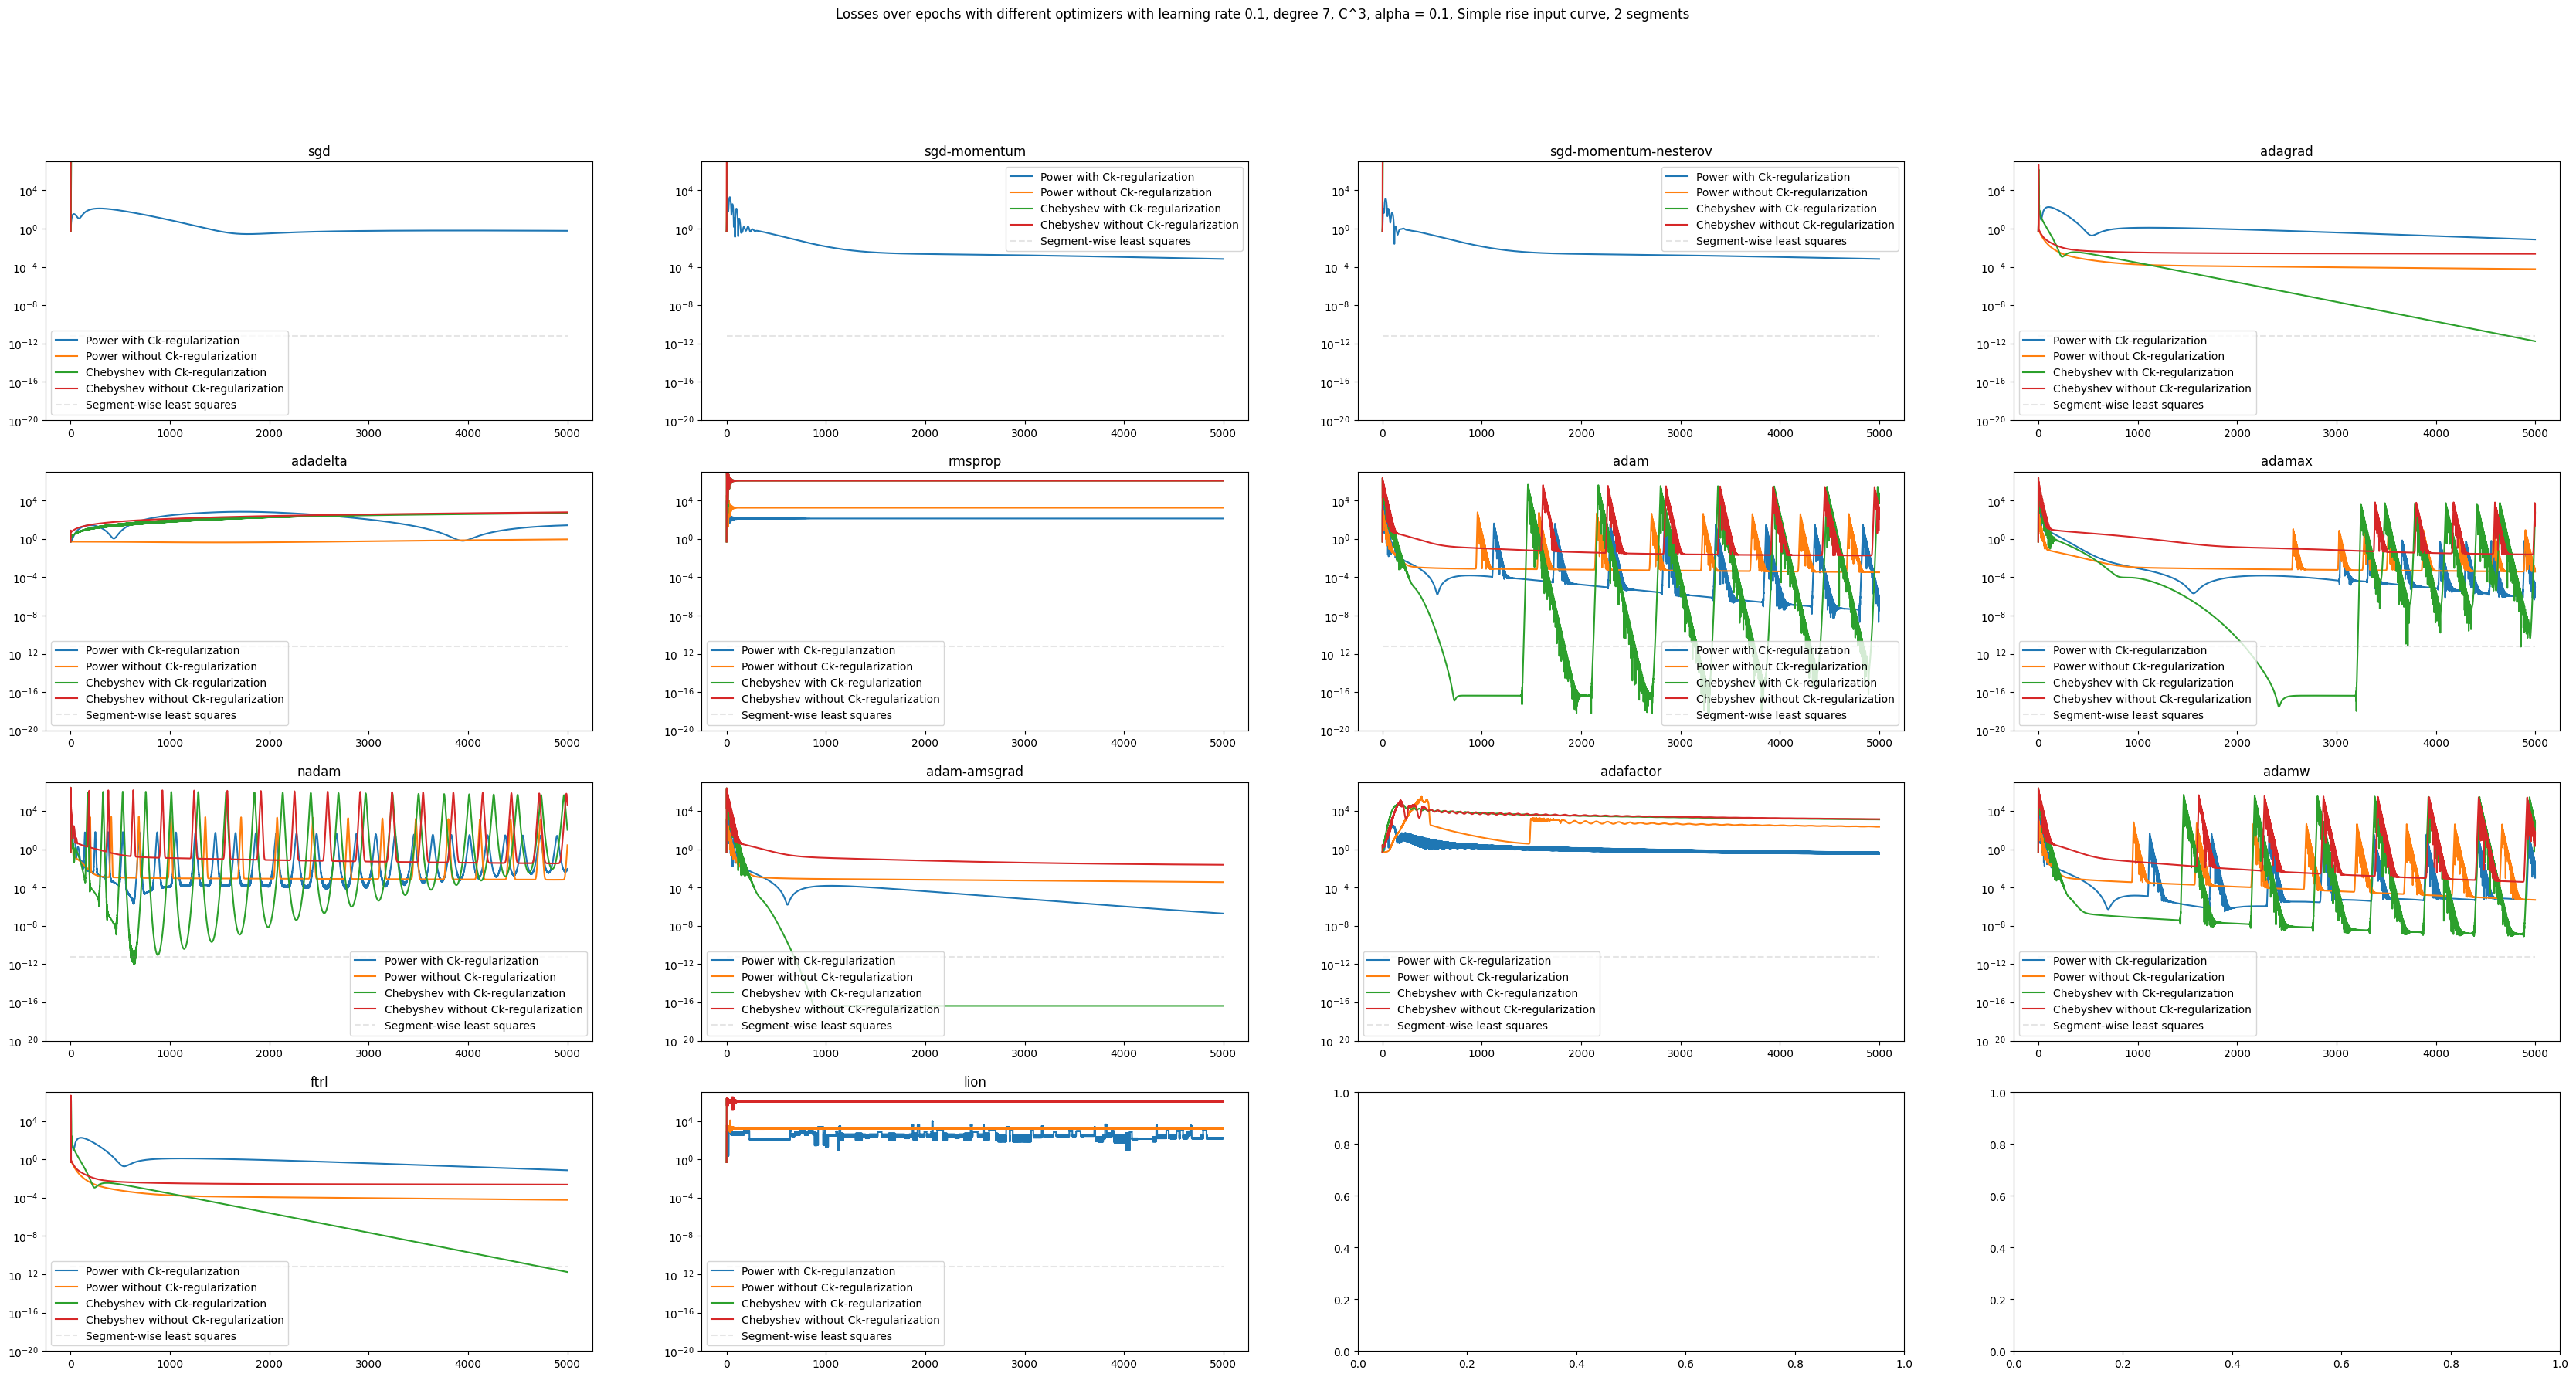

In [101]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha}, Simple rise input curve, {no_segments} segments')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_1[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_1[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_1[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_1[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

## Sine - 2 polynomials

In [96]:
no_segments = 2
data_x = xsin
data_y = ysin
factor_approximation_quality = 1 - alpha
factor_ck_pressure = alpha

In [45]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [46]:
losses_with_2 = copy.deepcopy(losses_with)
%store losses_with_2
losses_without_2 = copy.deepcopy(losses_without)
%store losses_without_2
losses_chebyshev_with_2 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_2
losses_chebyshev_without_2 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_2

Stored 'losses_with_2' (list)
Stored 'losses_without_2' (list)
Stored 'losses_chebyshev_with_2' (list)
Stored 'losses_chebyshev_without_2' (list)


In [47]:
%store -r losses_with_2
%store -r losses_without_2
%store -r losses_chebyshev_with_2
%store -r losses_chebyshev_without_2

Early stop: Achieved best result after 243 epochs. Exiting.


C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


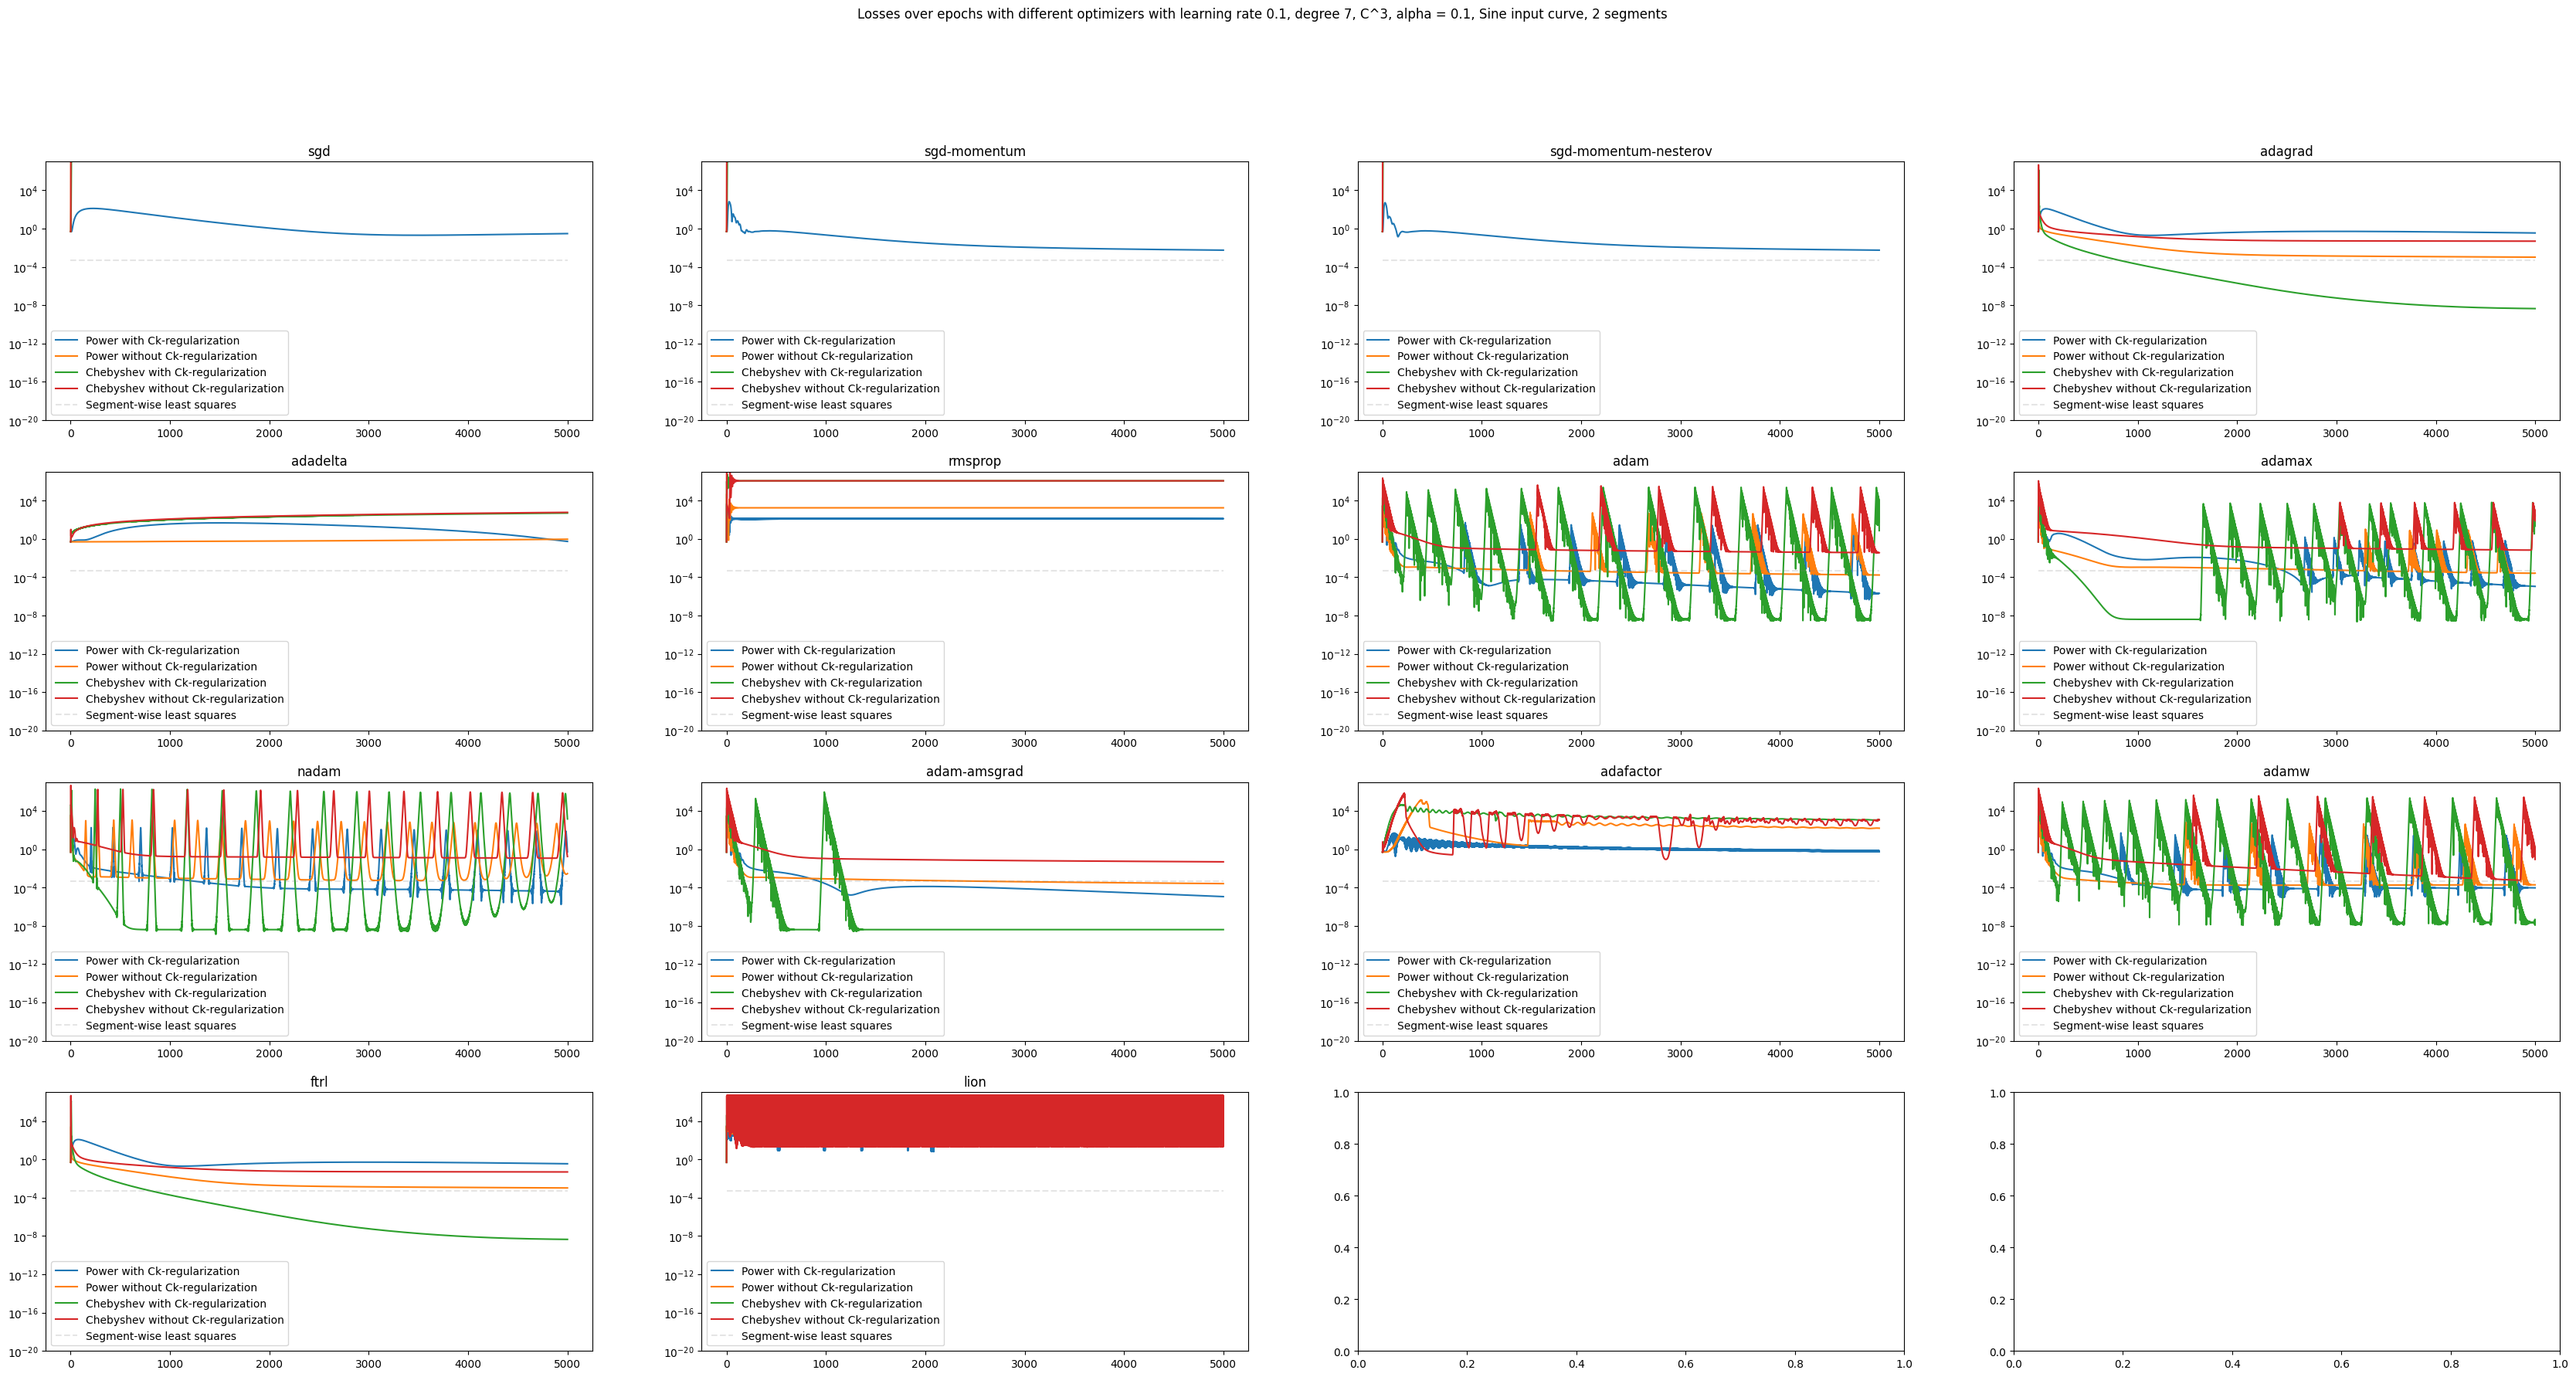

In [99]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha}, Sine input curve, {no_segments} segments')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_2[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_2[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_2[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_2[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

## Sine with varying frequency - 3 polynomials

In [102]:
no_segments = 3
data_x = xsinvar
data_y = ysinvar
factor_approximation_quality = 1 - alpha2
factor_ck_pressure = alpha2

In [50]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate, 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [51]:
losses_with_3 = copy.deepcopy(losses_with)
%store losses_with_3
losses_without_3 = copy.deepcopy(losses_without)
%store losses_without_3
losses_chebyshev_with_3 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_3
losses_chebyshev_without_3 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_3

Stored 'losses_with_3' (list)
Stored 'losses_without_3' (list)
Stored 'losses_chebyshev_with_3' (list)
Stored 'losses_chebyshev_without_3' (list)


In [52]:
%store -r losses_with_3
%store -r losses_without_3
%store -r losses_chebyshev_with_3
%store -r losses_chebyshev_without_3

Early stop: Achieved best result after 144 epochs. Exiting.


C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


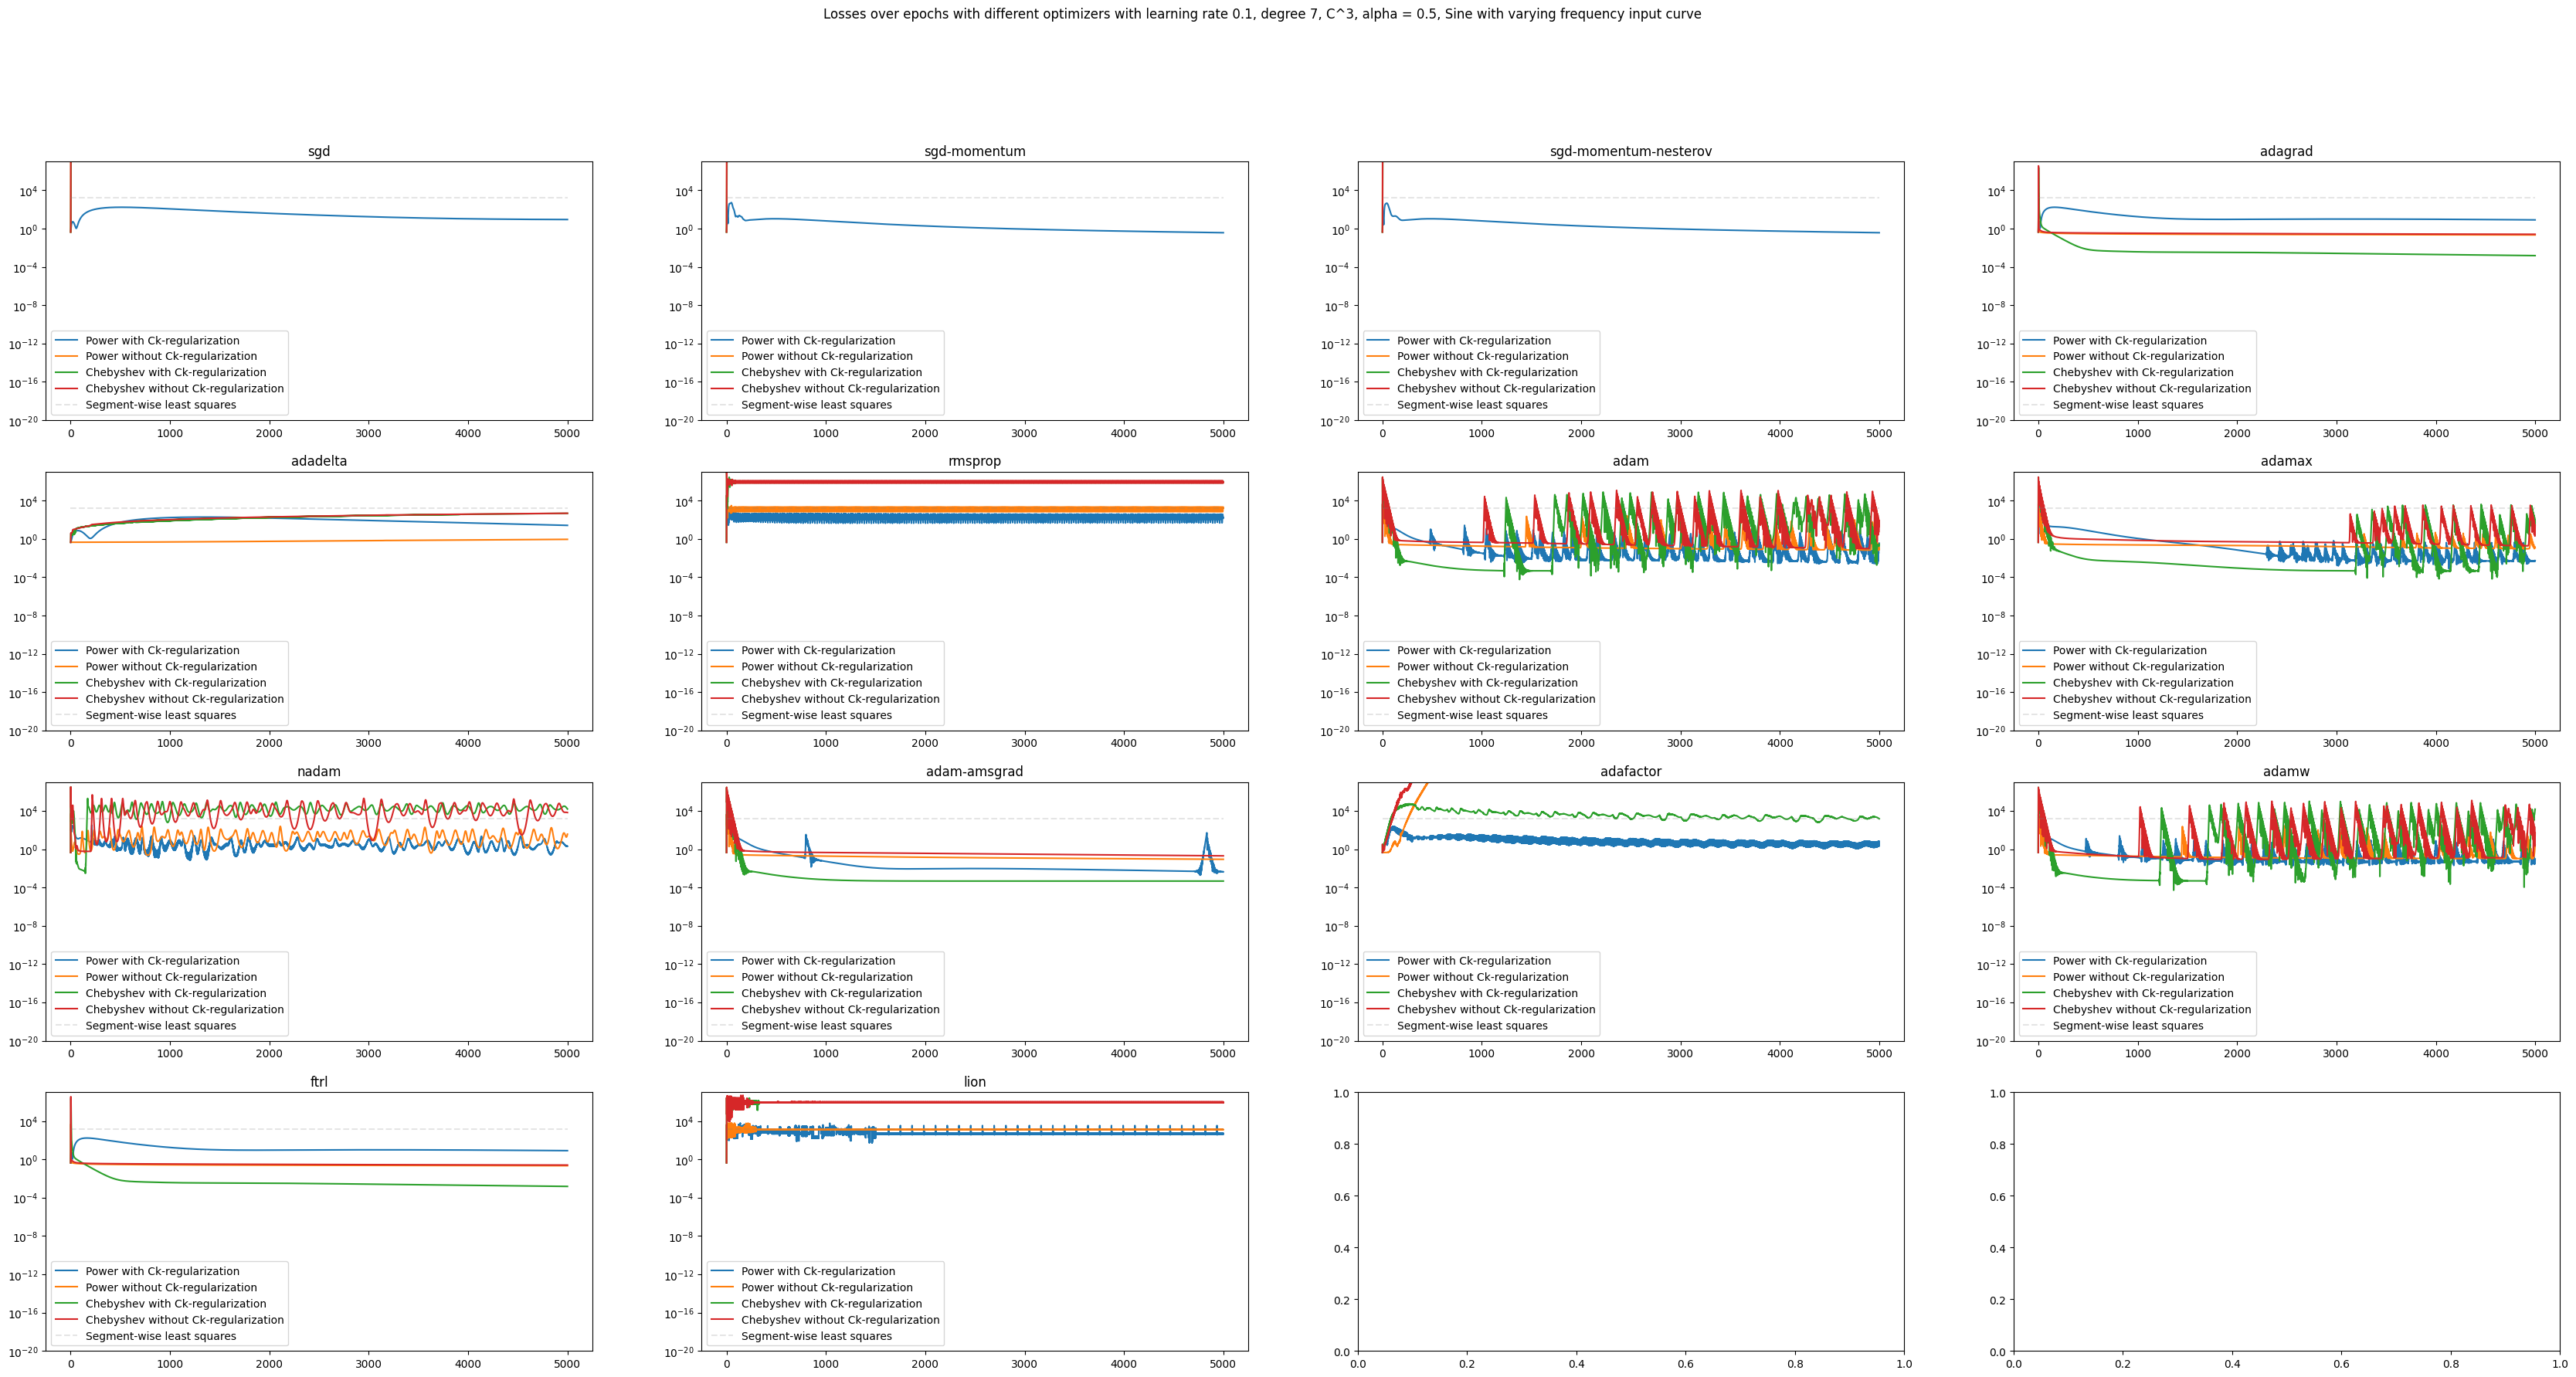

In [103]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha2}, Sine with varying frequency input curve')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_3[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_3[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_3[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_3[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

## Noisy input - 3 polynomials

In [104]:
no_segments = 3
data_x = xsinvar
data_y = ys2gauss[2]
factor_approximation_quality = 1 - alpha3
factor_ck_pressure = alpha3

In [55]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [56]:
losses_with_4 = copy.deepcopy(losses_with)
%store losses_with_4
losses_without_4 = copy.deepcopy(losses_without)
%store losses_without_4
losses_chebyshev_with_4 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_4
losses_chebyshev_without_4 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_4

Stored 'losses_with_4' (list)
Stored 'losses_without_4' (list)
Stored 'losses_chebyshev_with_4' (list)
Stored 'losses_chebyshev_without_4' (list)


In [57]:
%store -r losses_with_4
%store -r losses_without_4
%store -r losses_chebyshev_with_4
%store -r losses_chebyshev_without_4

Early stop: Achieved best result after 96 epochs. Exiting.


C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


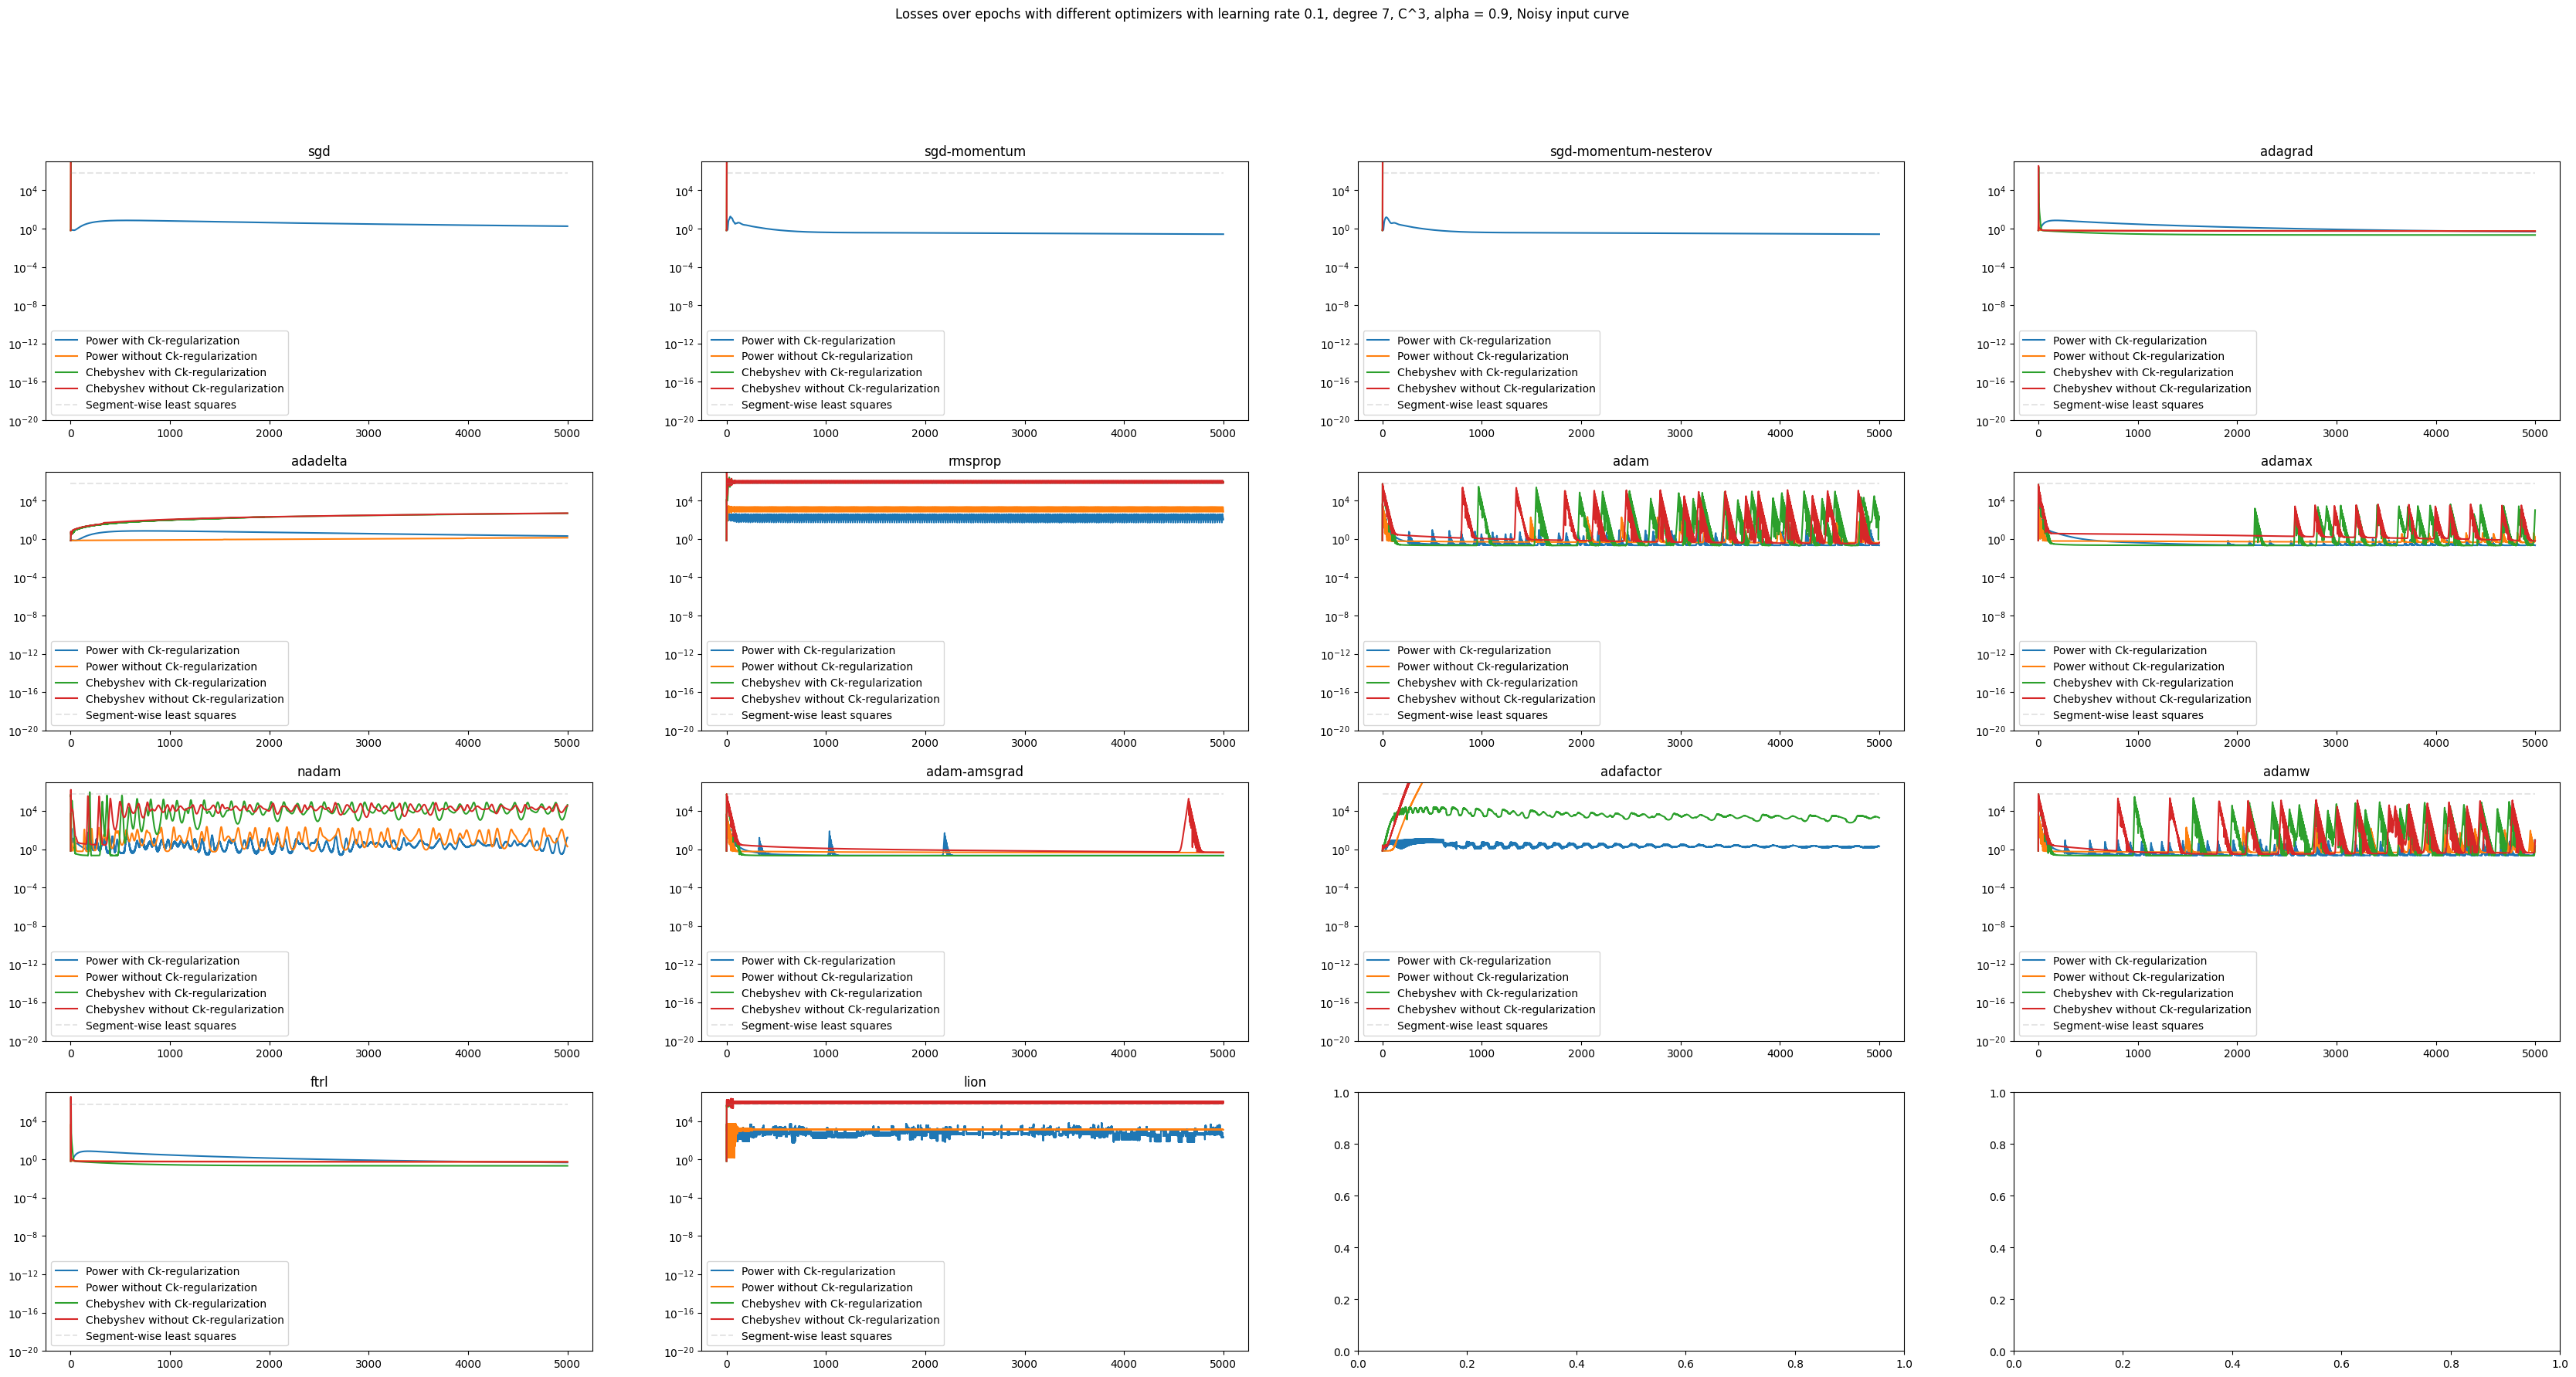

In [106]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha3}, Noisy input curve')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_4[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_4[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_4[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_4[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

## Interpretation
Chebyshev is clearly outperforming Power Basis in regard to all observed optimizers and input point sets.
**None of the optimizers manage to surpass the l2 optimum with Power basis in the given 5000 epochs for the lowest variance input data (name in this notebook: Simple rise curve).**
**There are, however, several optimizers that achieve this with Chebyshev basis.**
The more variance is in the input data, the higher is the loss for the l2 baseline with CK loss.
The more variance is in the input data, the more optimizers (also with Power basis) manage to surpass this l2 baseline.
The following optimizer candidates surpass the l2 baseline with all observed input data:
1. adam
2. adam amsgrad
3. adamax
4. adagrad, ftrl
5. nadam

Considering all observed input data, Adam AMSGrad is the best candidate.


# $\ell_2$ initialization

In [107]:
no_segments = 2
data_x = xs2
data_y = ys2
factor_approximation_quality = 1 - alpha
factor_ck_pressure = alpha

In [60]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [61]:
losses_with_5 = copy.deepcopy(losses_with)
%store losses_with_5
losses_without_5 = copy.deepcopy(losses_without)
%store losses_without_5
losses_chebyshev_with_5 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_5
losses_chebyshev_without_5 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_5

Stored 'losses_with_5' (list)
Stored 'losses_without_5' (list)
Stored 'losses_chebyshev_with_5' (list)
Stored 'losses_chebyshev_without_5' (list)


In [62]:
%store -r losses_with_5
%store -r losses_without_5
%store -r losses_chebyshev_with_5
%store -r losses_chebyshev_without_5

C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


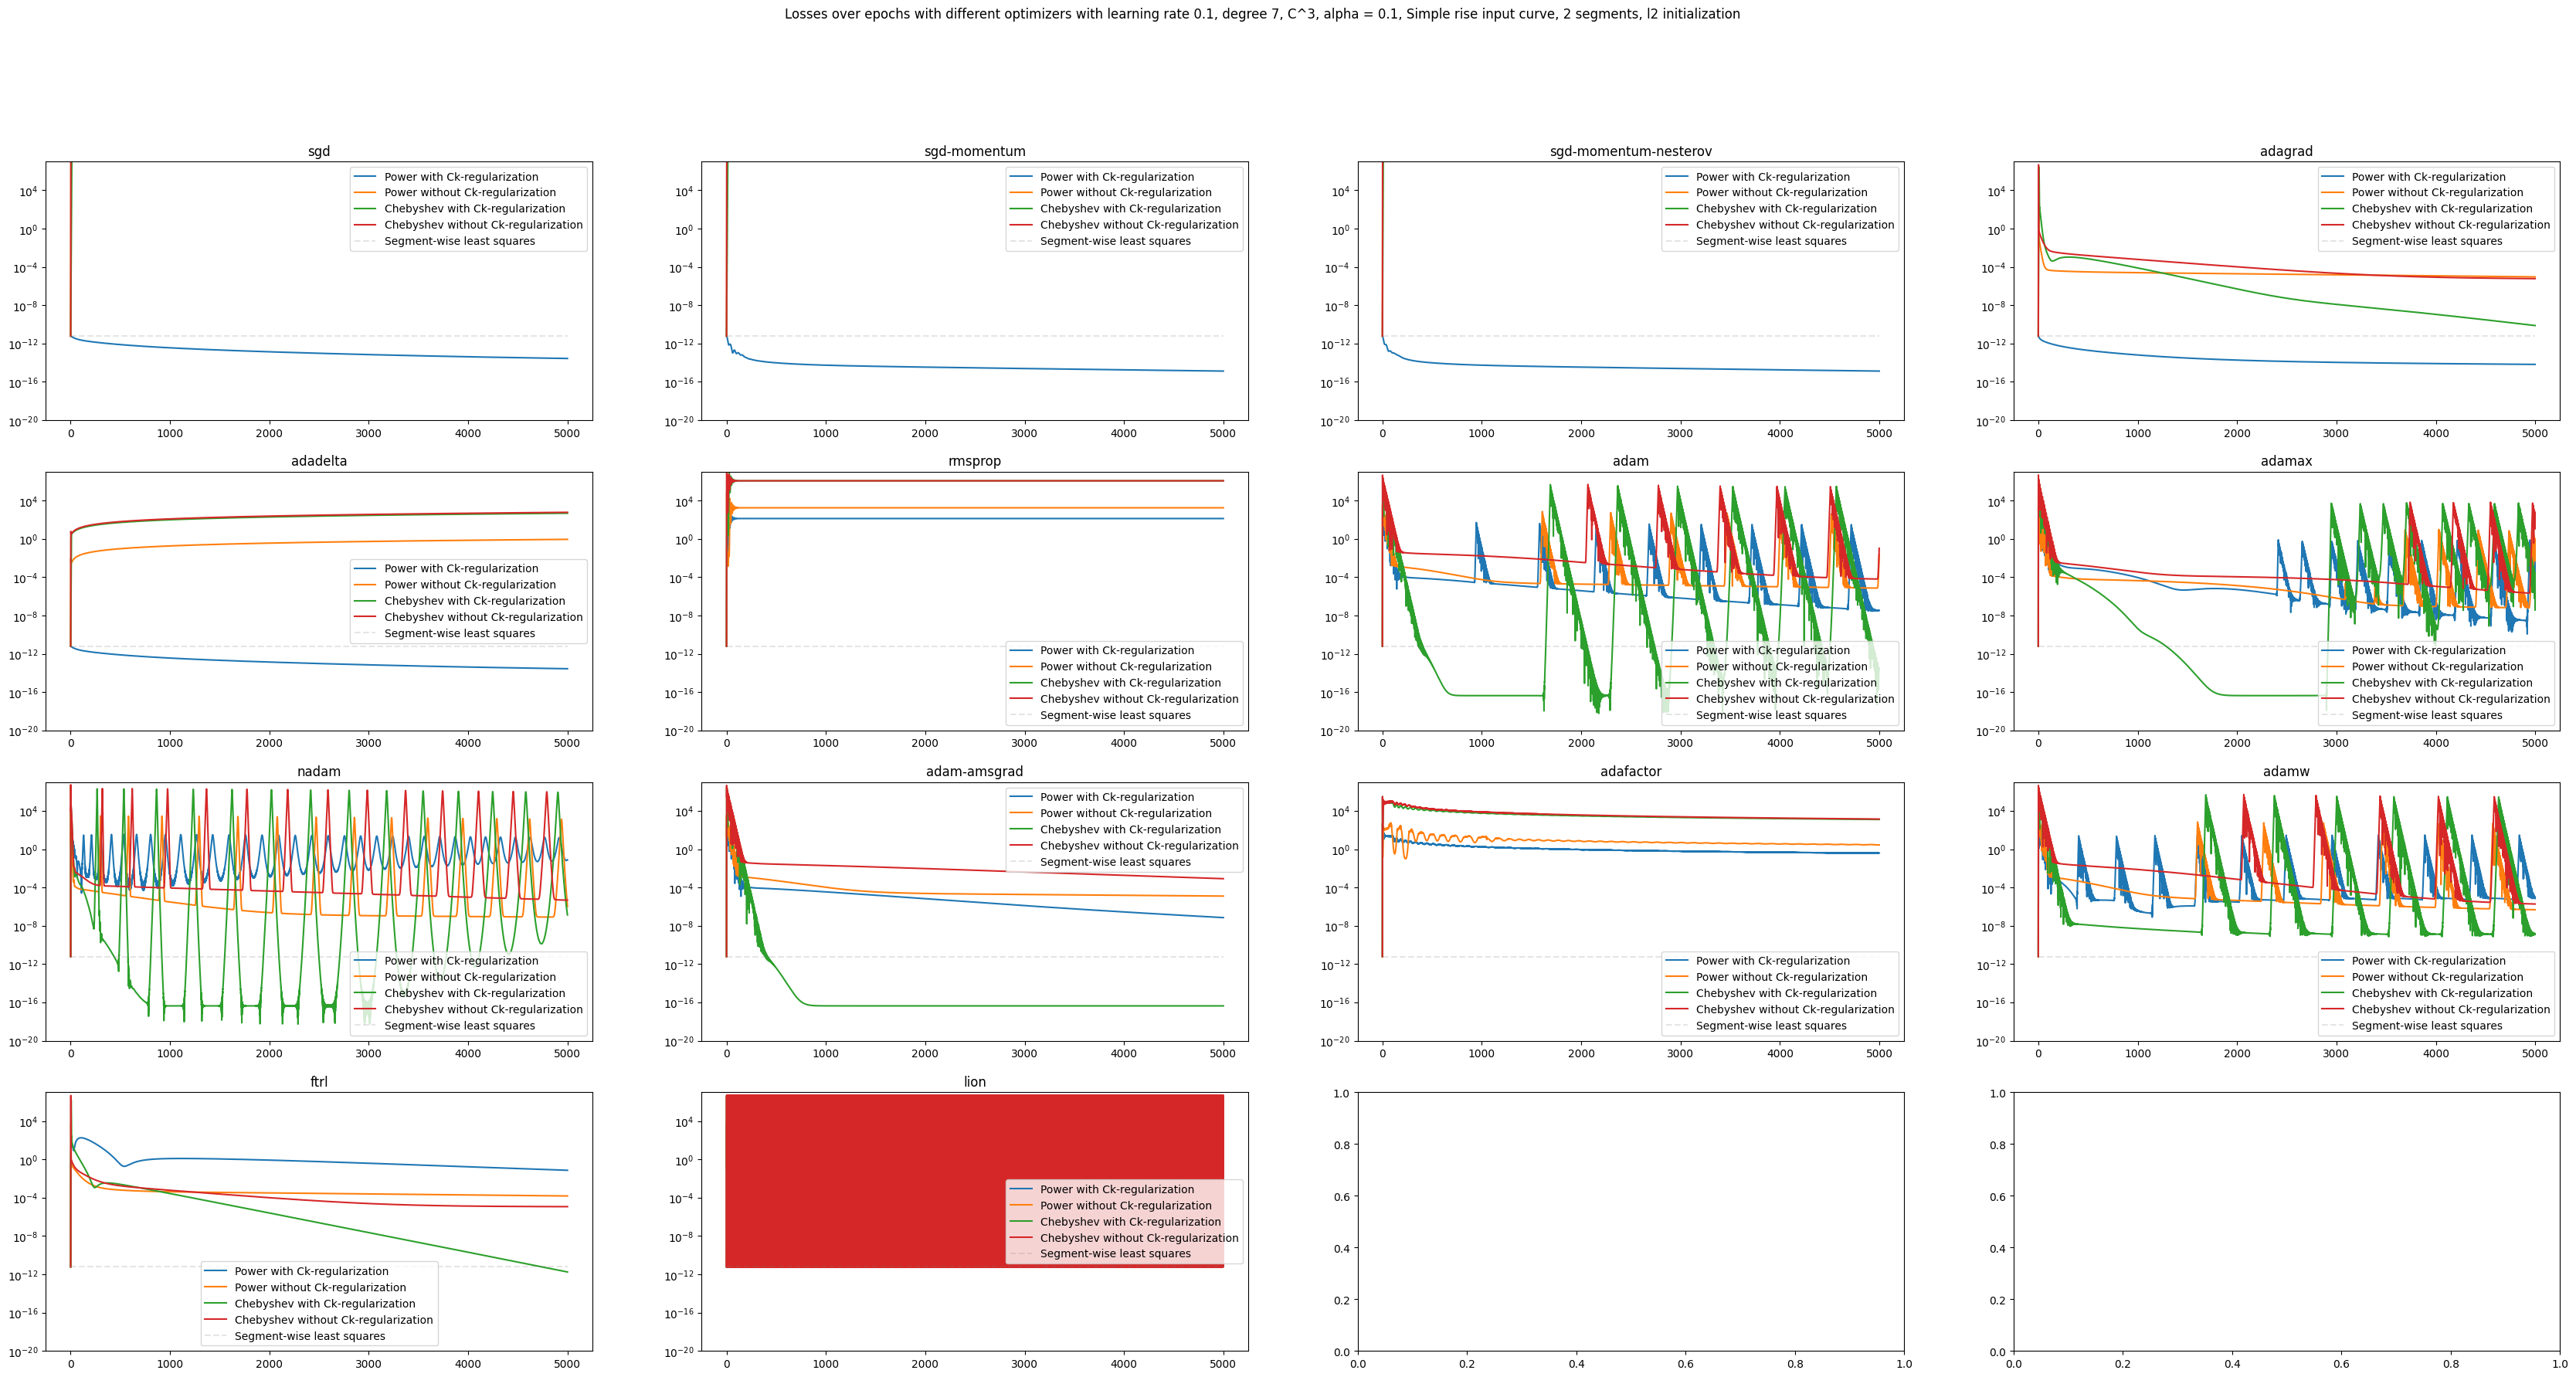

In [108]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha}, Simple rise input curve, {no_segments} segments, l2 initialization')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_5[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_5[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_5[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_5[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

In [109]:
no_segments = 2
data_x = xsin
data_y = ysin
factor_approximation_quality = 1 - alpha
factor_ck_pressure = alpha

In [65]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [66]:
losses_with_6 = copy.deepcopy(losses_with)
%store losses_with_6
losses_without_6 = copy.deepcopy(losses_without)
%store losses_without_6
losses_chebyshev_with_6 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_6
losses_chebyshev_without_6 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_6

Stored 'losses_with_6' (list)
Stored 'losses_without_6' (list)
Stored 'losses_chebyshev_with_6' (list)
Stored 'losses_chebyshev_without_6' (list)


In [67]:
%store -r losses_with_6
%store -r losses_without_6
%store -r losses_chebyshev_with_6
%store -r losses_chebyshev_without_6

Early stop: Achieved best result after 243 epochs. Exiting.


C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


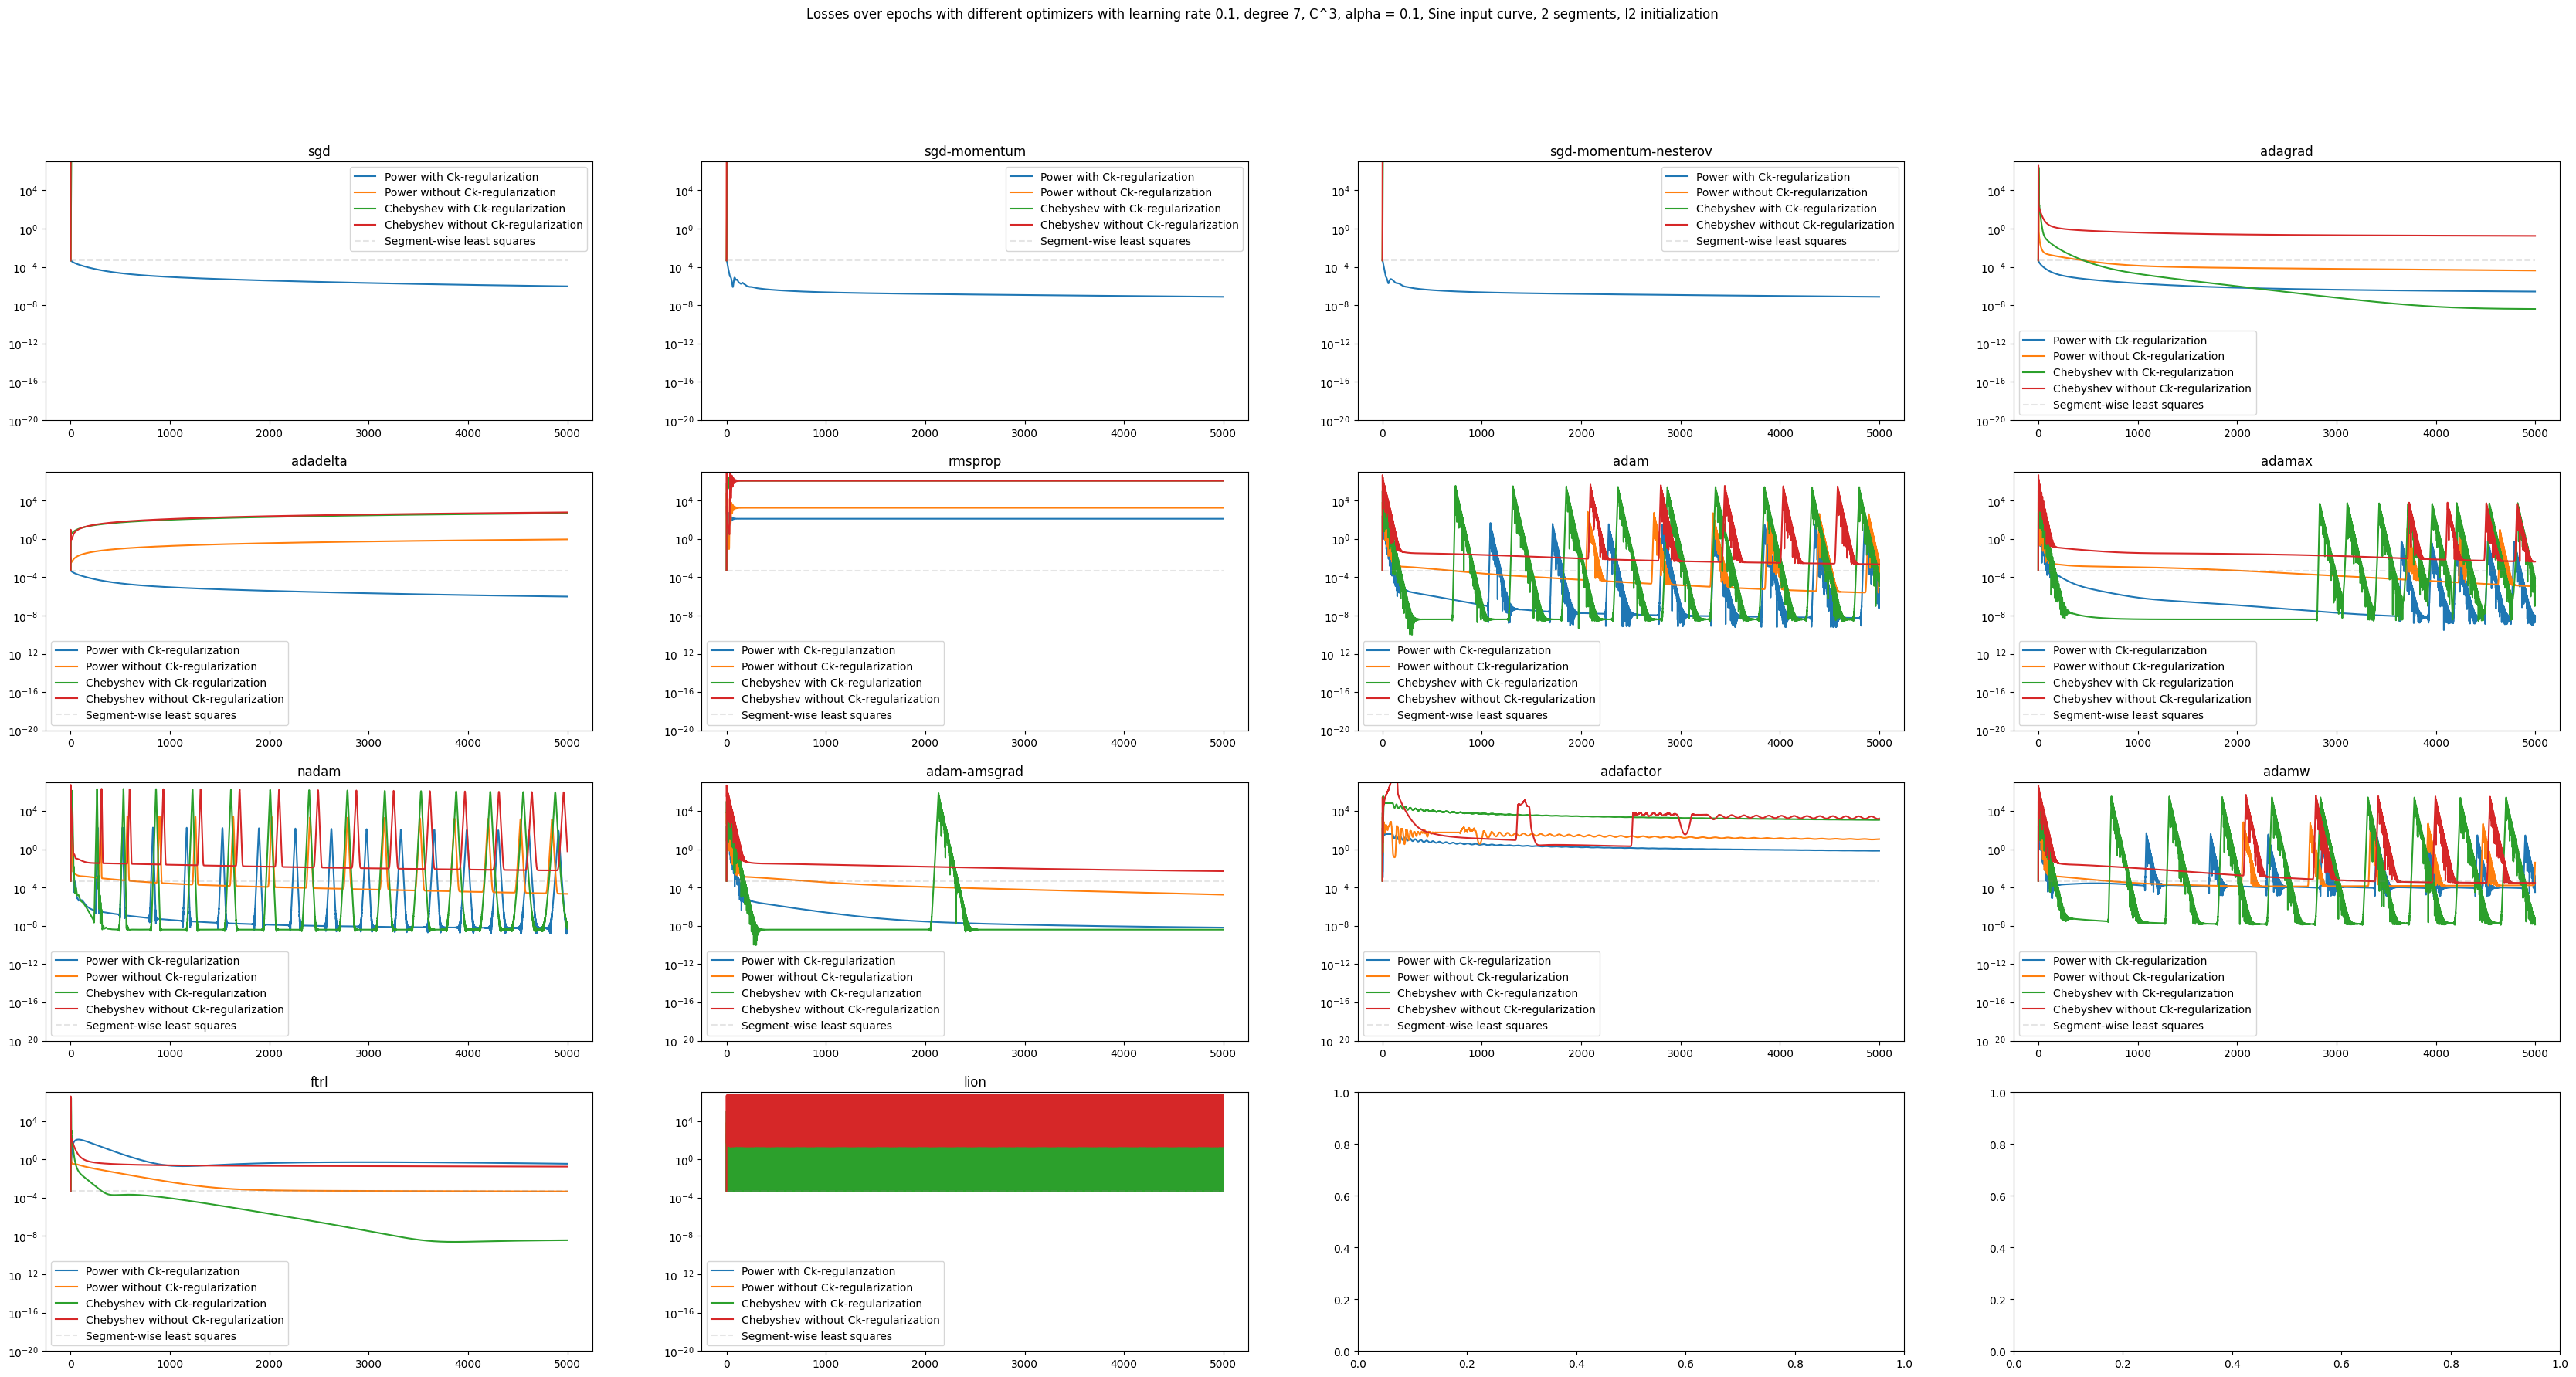

In [110]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha}, Sine input curve, {no_segments} segments, l2 initialization')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_6[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_6[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_6[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_6[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

In [111]:
no_segments = 3
data_x = xsinvar
data_y = ysinvar
factor_approximation_quality = 1 - alpha2
factor_ck_pressure = alpha2

In [70]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [71]:
losses_with_7 = copy.deepcopy(losses_with)
%store losses_with_7
losses_without_7 = copy.deepcopy(losses_without)
%store losses_without_7
losses_chebyshev_with_7 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_7
losses_chebyshev_without_7 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_7

Stored 'losses_with_7' (list)
Stored 'losses_without_7' (list)
Stored 'losses_chebyshev_with_7' (list)
Stored 'losses_chebyshev_without_7' (list)


In [72]:
%store -r losses_with_7
%store -r losses_without_7
%store -r losses_chebyshev_with_7
%store -r losses_chebyshev_without_7

Early stop: Achieved best result after 144 epochs. Exiting.


C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


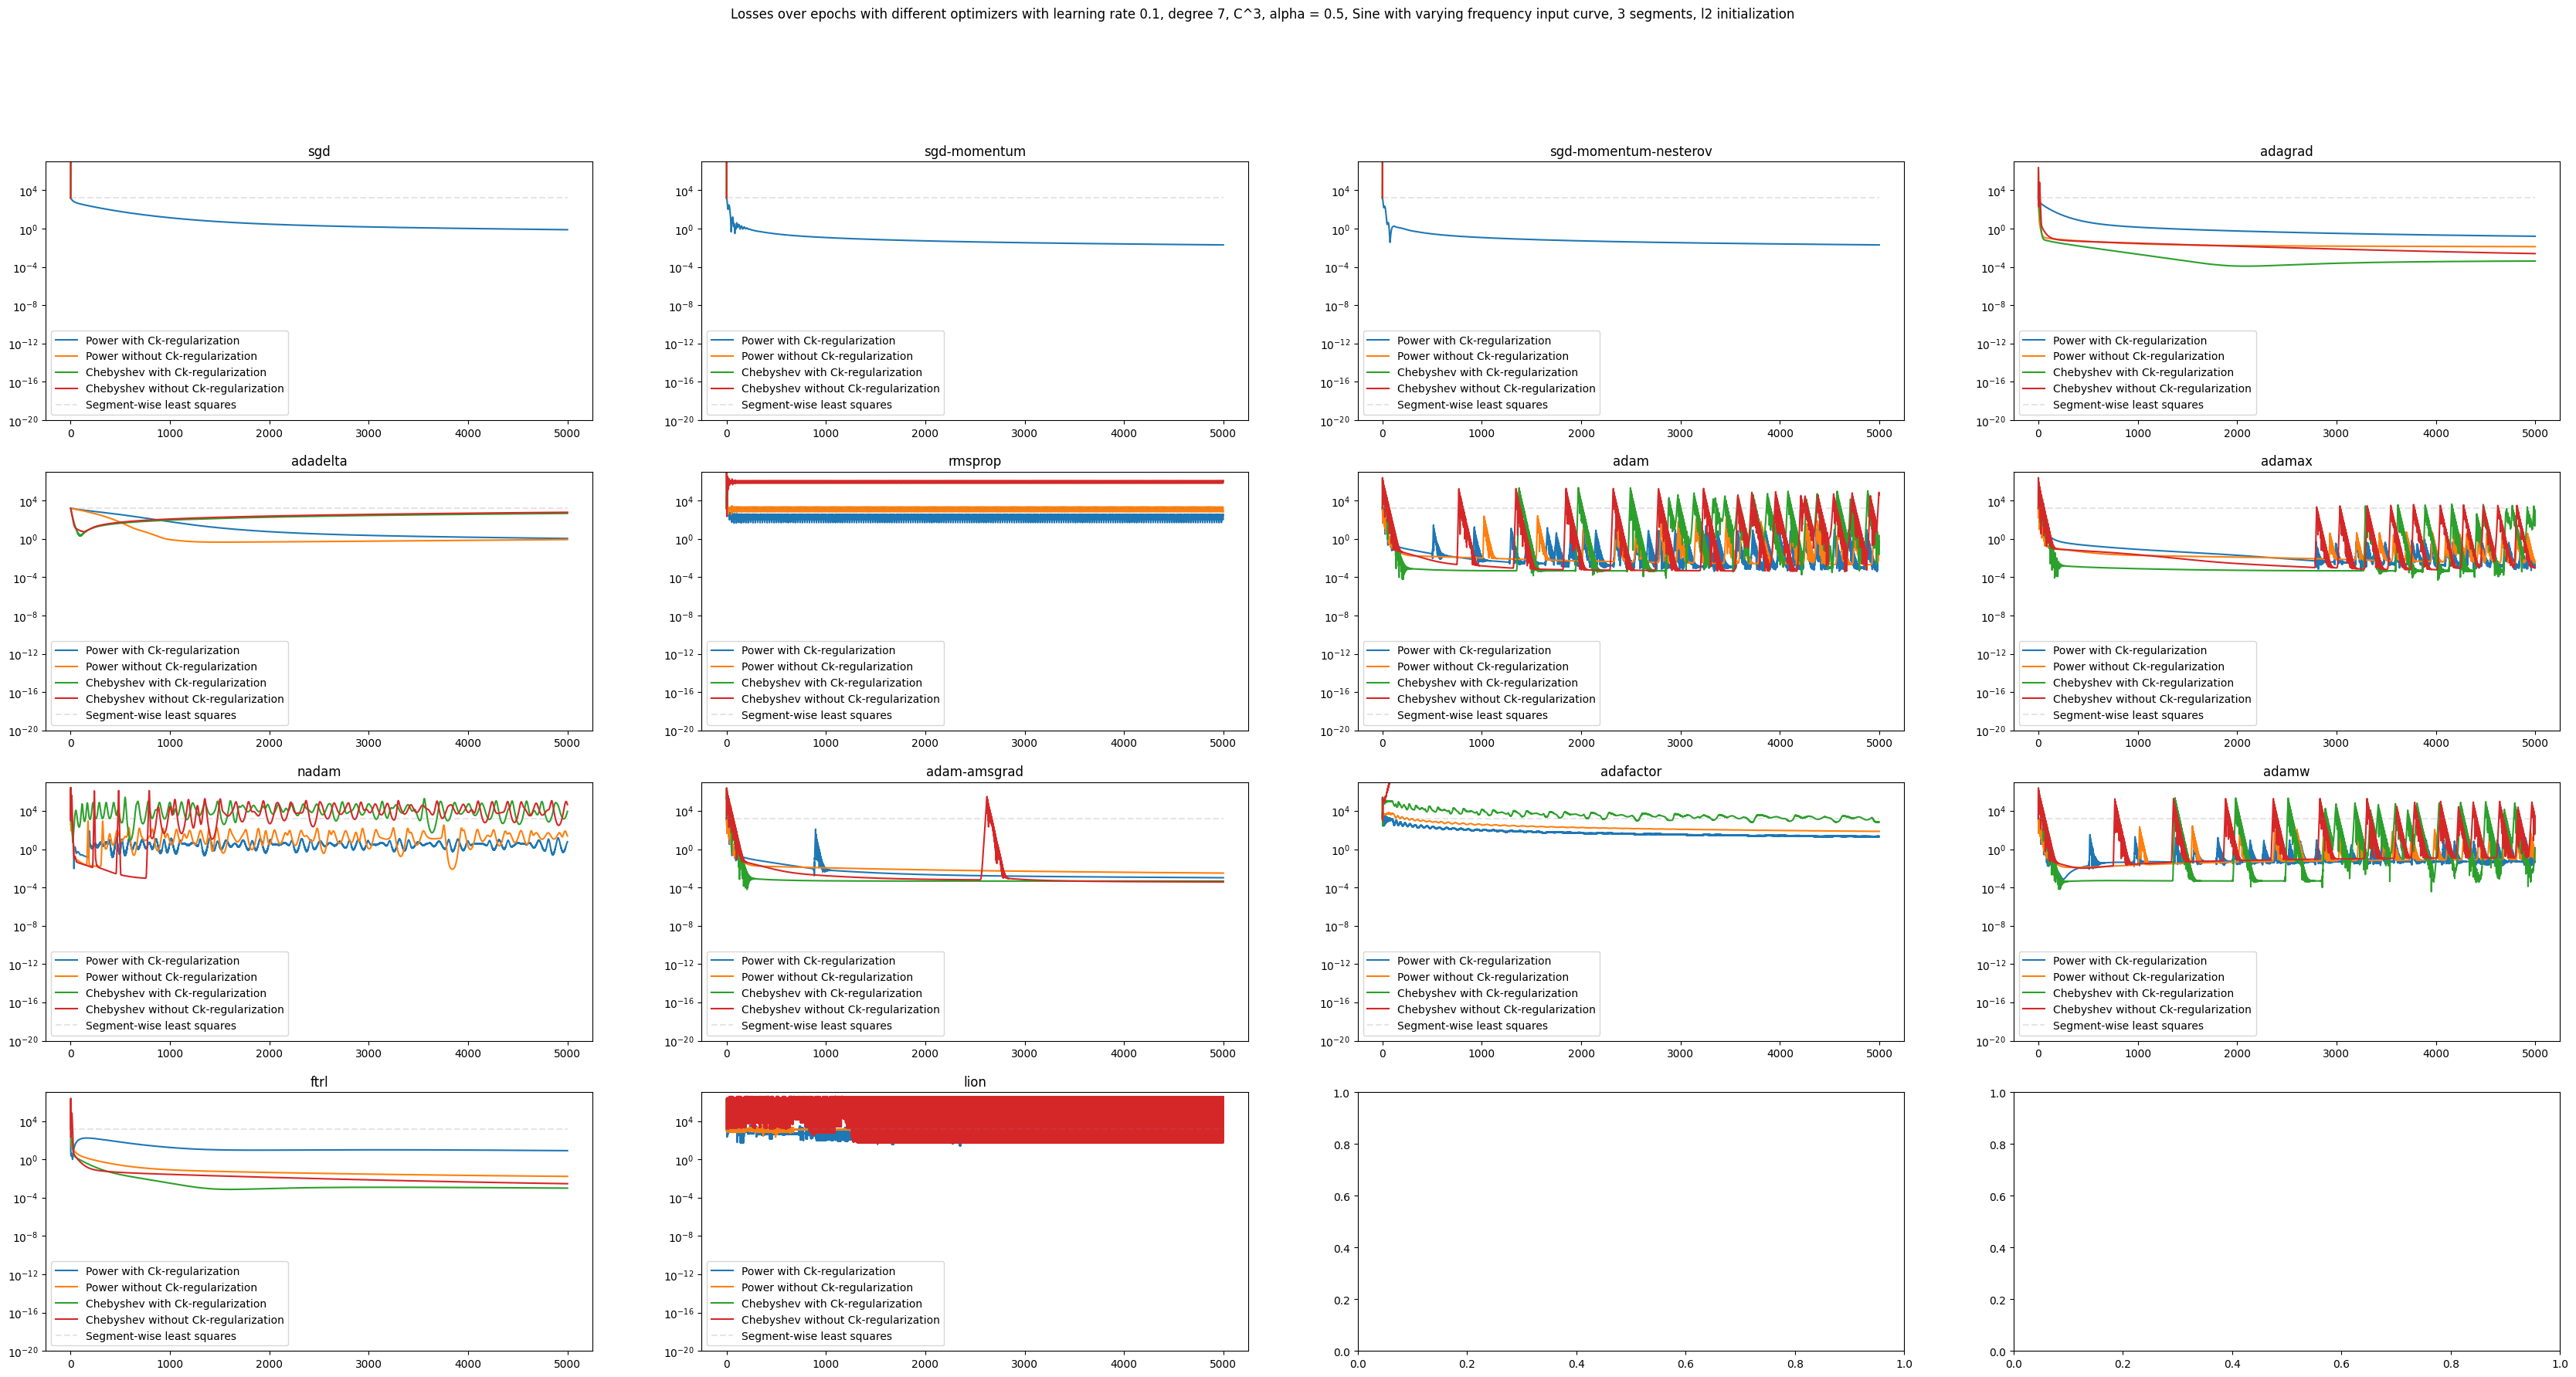

In [112]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha2}, Sine with varying frequency input curve, {no_segments} segments, l2 initialization')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_7[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_7[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_7[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_7[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

In [113]:
no_segments = 3
data_x = xsinvar
data_y = ys2gauss[2]
factor_approximation_quality = 1 - alpha3
factor_ck_pressure = alpha3

In [75]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'power'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': True, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'n_epochs': epochs, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure,
        'ck_regularization': False, 'initialization': 'l2', 'basis': 'chebyshev'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

# get total loss values of every entry
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_without)
losses_chebyshev_with = [0.0] * len(results_chebyshev_with)
losses_chebyshev_without = [0.0] * len(results_chebyshev_without)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_chebyshev_with[i] = results_chebyshev_with[i][1]
    losses_chebyshev_without[i] = results_chebyshev_without[i][1]

In [76]:
losses_with_8 = copy.deepcopy(losses_with)
%store losses_with_8
losses_without_8 = copy.deepcopy(losses_without)
%store losses_without_8
losses_chebyshev_with_8 = copy.deepcopy(losses_chebyshev_with)
%store losses_chebyshev_with_8
losses_chebyshev_without_8 = copy.deepcopy(losses_chebyshev_without)
%store losses_chebyshev_without_8

Stored 'losses_with_8' (list)
Stored 'losses_without_8' (list)
Stored 'losses_chebyshev_with_8' (list)
Stored 'losses_chebyshev_without_8' (list)


In [77]:
%store -r losses_with_8
%store -r losses_without_8
%store -r losses_chebyshev_with_8
%store -r losses_chebyshev_without_8

Early stop: Achieved best result after 96 epochs. Exiting.


C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


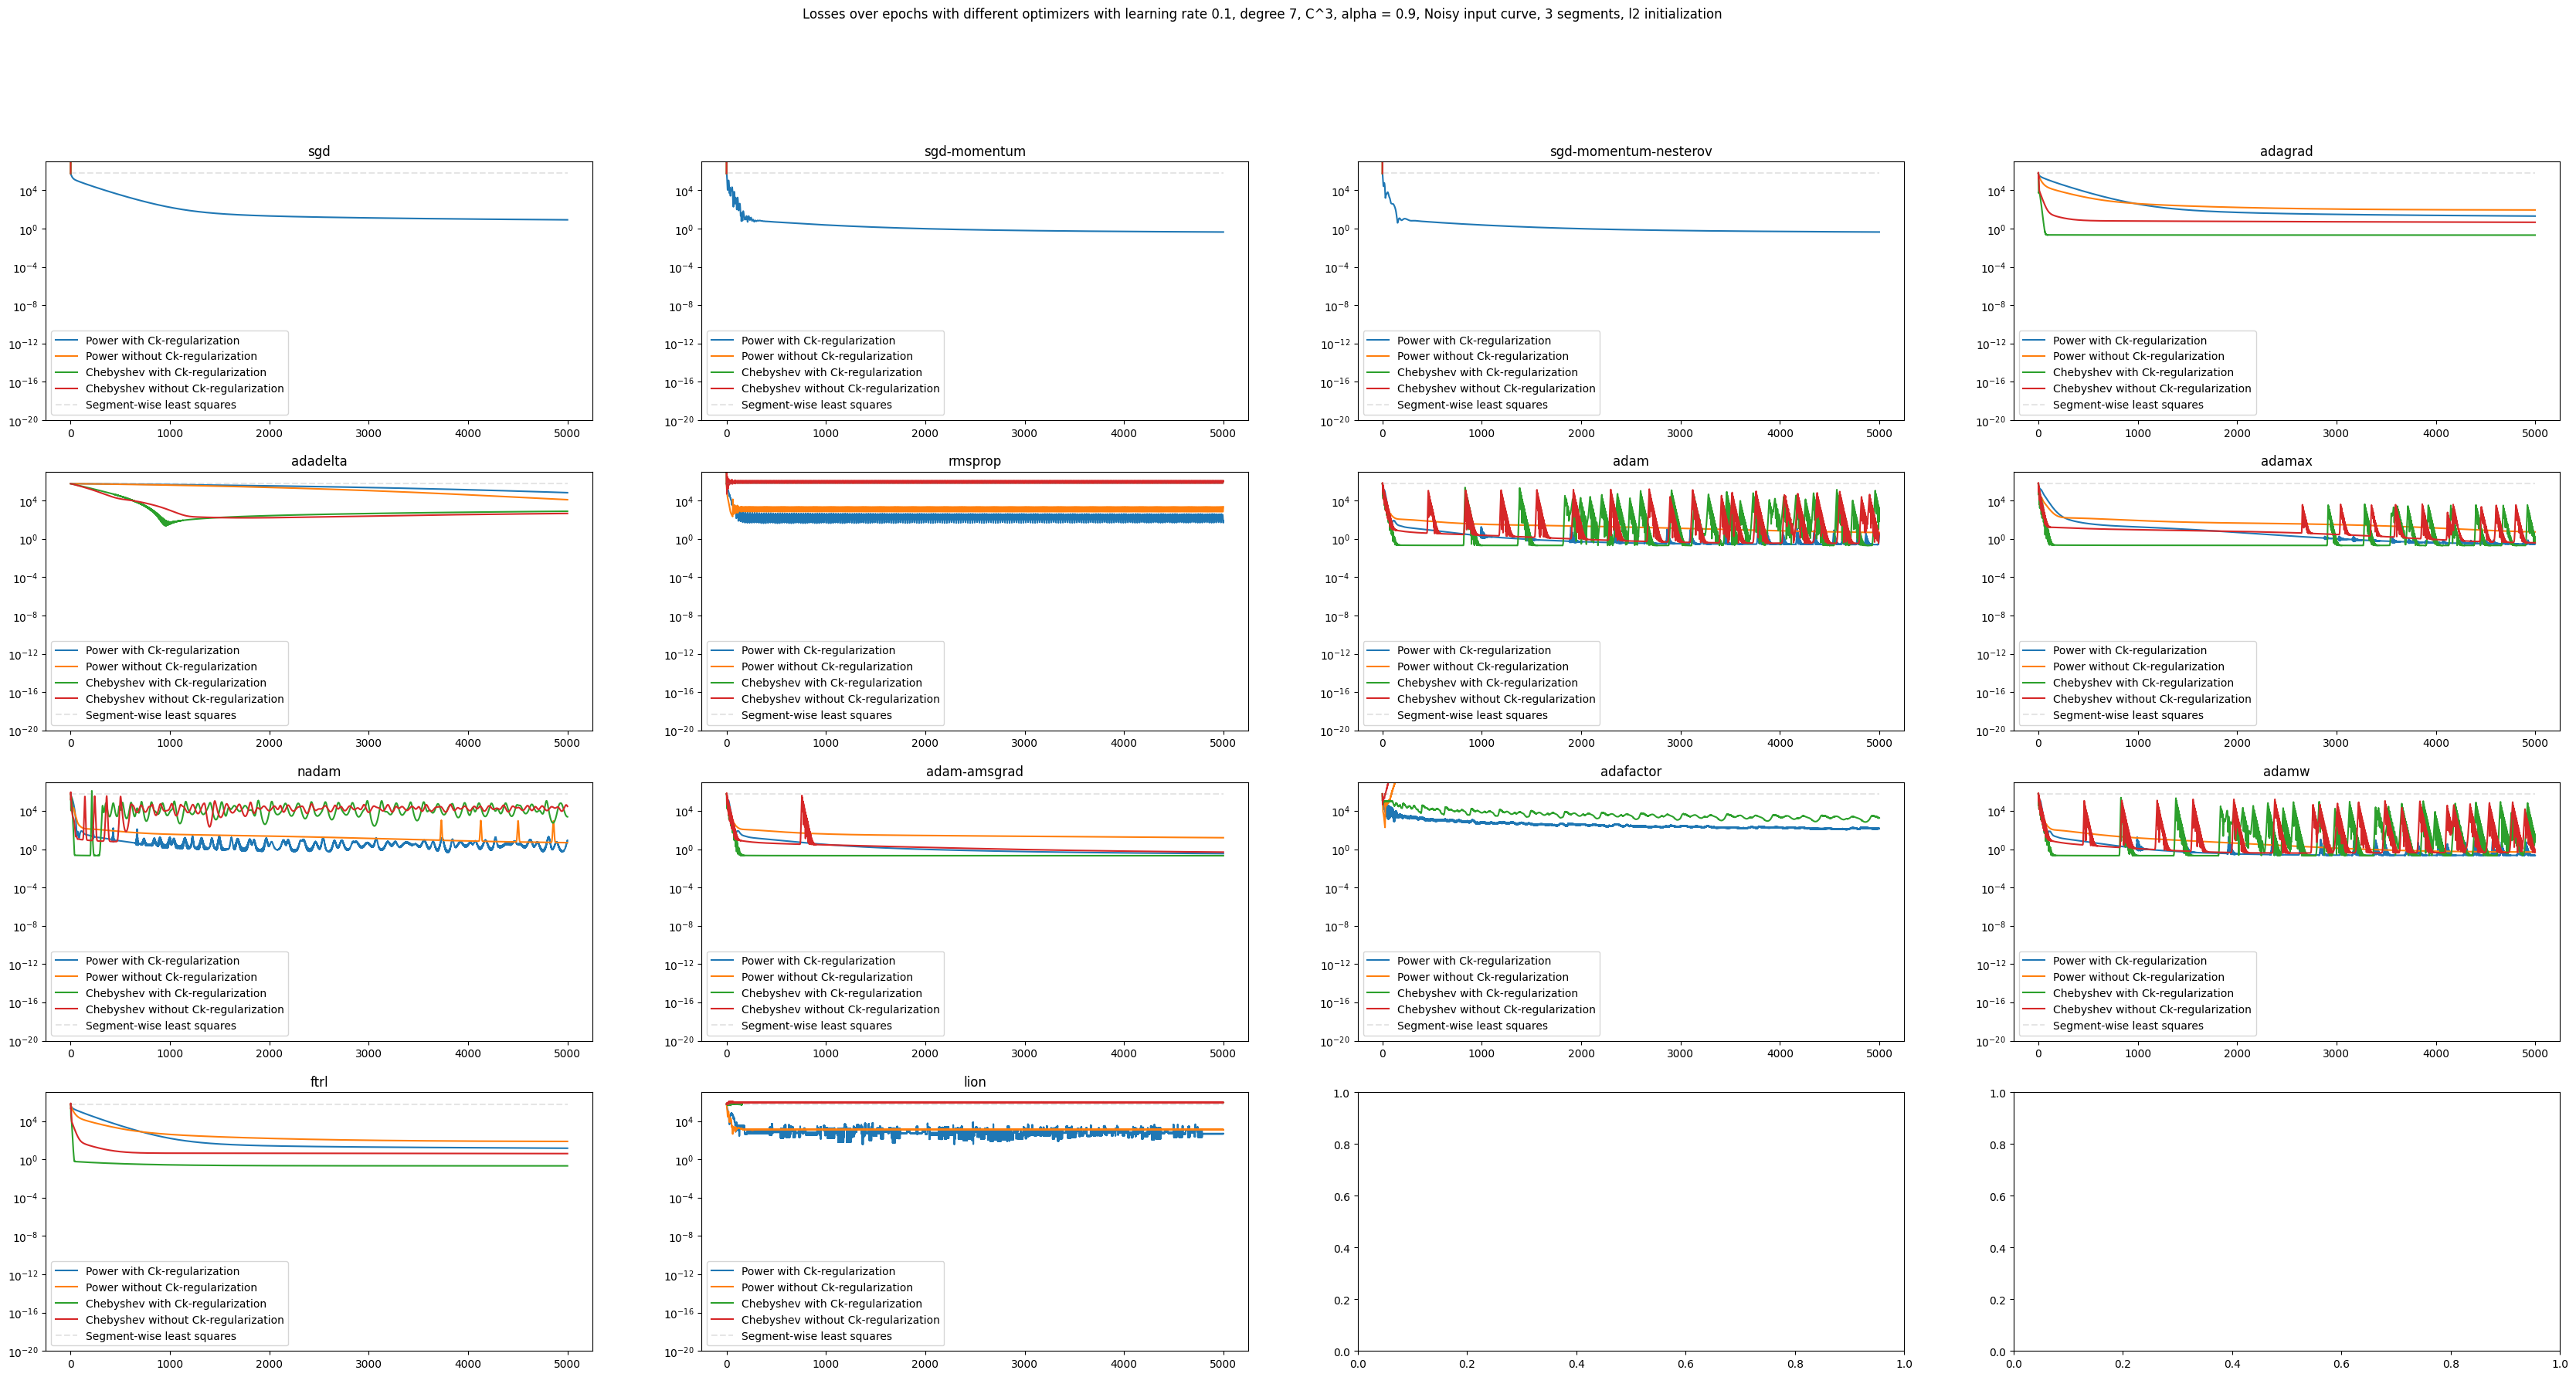

In [114]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate {learning_rate}, degree {degree}, C^{ck}, alpha = {alpha3}, Noisy input curve, {no_segments} segments, l2 initialization')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(data_x, data_y, epochs=1)
opt = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)
optloss = opt[0]+opt[1]

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_8[i], label="Power with Ck-regularization")
    ax.semilogy(losses_without_8[i], label="Power without Ck-regularization")
    ax.semilogy(losses_chebyshev_with_8[i], label="Chebyshev with Ck-regularization")
    ax.semilogy(losses_chebyshev_without_8[i], label="Chebyshev without Ck-regularization")
    ax.hlines(optloss, xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Segment-wise least squares")
    ax.set_ylim([1e-20, 1e7])
    ax.legend(loc="best")

## Interpretation

With least squares fit initialization of polynomial coefficients, Power basis gets competitive again.
However, Chebyshev basis with AMSGrad still shows the best convergence behaviour.

## Investigating AMSGrad parameters

## beta1

In [115]:
epochs = 2000
no_segments = 2
data_x = xs2
data_y = ys2
factor_approximation_quality = 1 - alpha
factor_ck_pressure = alpha
beta_1s = [b for b in np.arange(0.6, 1.001, 0.1)]

In [116]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'learning_rate': learning_rate , 'mode': 'amsgrad-beta1',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [117]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'learning_rate': learning_rate , 'mode': 'amsgrad-beta1',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [118]:
# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]

Text(0.5, 1.0, 'Chebyshev Basis')

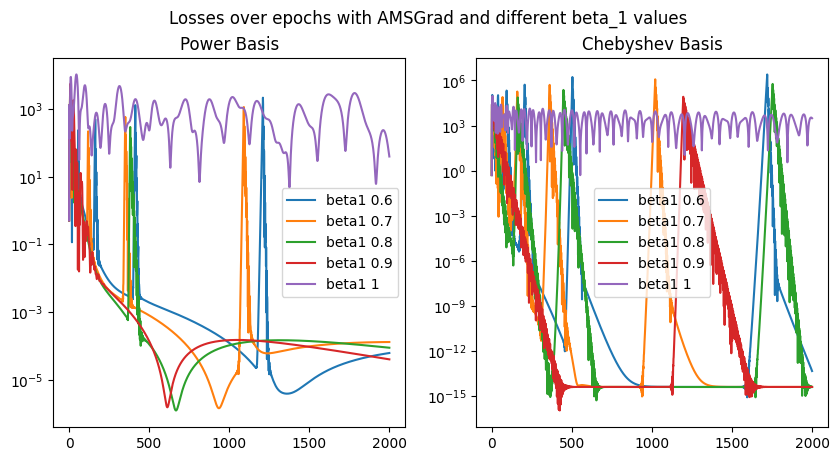

In [119]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(beta_1s)*2)
fig.suptitle("Losses over epochs with AMSGrad and different beta_1 values")

for i, b1 in enumerate(beta_1s):
    ax1.semilogy(losses[i], label="beta1 %.2g" % b1)
    ax2.semilogy(losses_chebyshev[i], label="beta1 %.2g" % b1)

for ax in (ax1, ax2):
    #ax.set_ylim([1e-10, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")

### Interpretation
**The default of 0.9 is ok for all bases**

## beta2

In [120]:
vals = [b for b in np.arange(0.990, 0.999, 0.001)]

In [121]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power','learning_rate': learning_rate , 'mode': 'amsgrad-beta2',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(vals, repeat(kwargs)))

In [122]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev','learning_rate': learning_rate , 'mode': 'amsgrad-beta2',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(vals, repeat(kwargs)))

In [123]:
# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]

Text(0.5, 1.0, 'Chebyshev Basis')

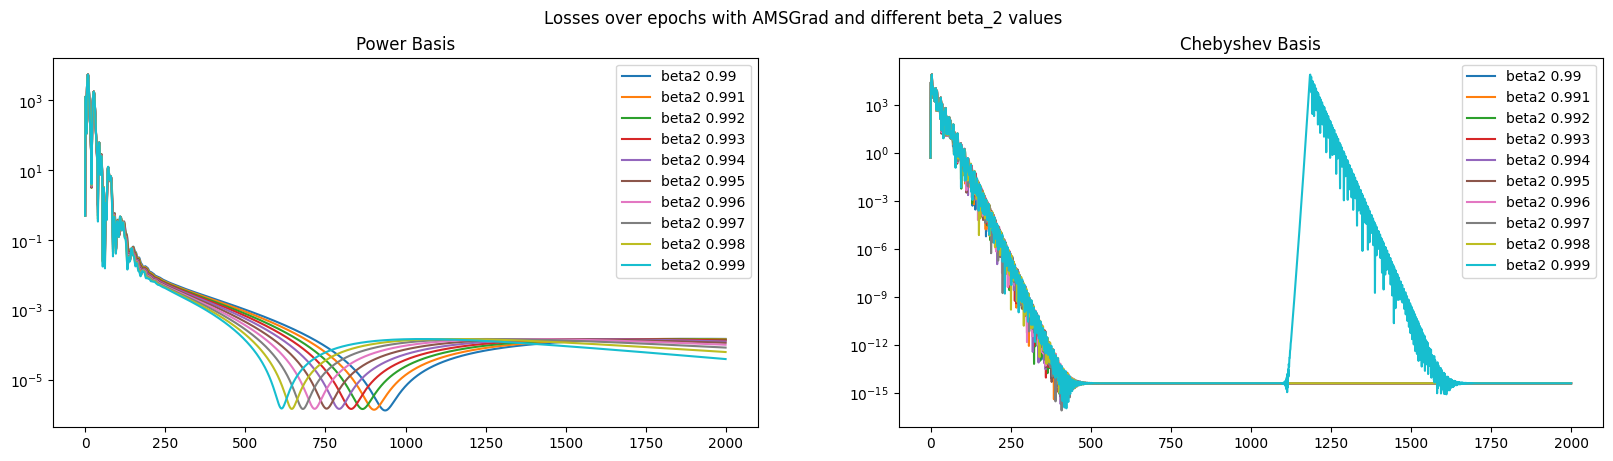

In [124]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(vals)*2)
fig.suptitle("Losses over epochs with AMSGrad and different beta_2 values")

for i, v in enumerate(vals):
    ax1.semilogy(losses[i], label="beta2 %.3g" % v)
    ax2.semilogy(losses_chebyshev[i], label="beta2 %.3g" % v)

for ax in (ax1, ax2):
    #ax.set_ylim([1e-10, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")

### Interpretation

**The default of 0.999 is ok for all bases.**

## Weight decay

In [125]:
vals = [False, True]

In [126]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power','learning_rate': learning_rate , 'mode': 'amsgrad-weight_decay',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(vals, repeat(kwargs)))

In [127]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev','learning_rate': learning_rate , 'mode': 'amsgrad-weight_decay',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(vals, repeat(kwargs)))

In [128]:
# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]

Text(0.5, 1.0, 'Chebyshev Basis')

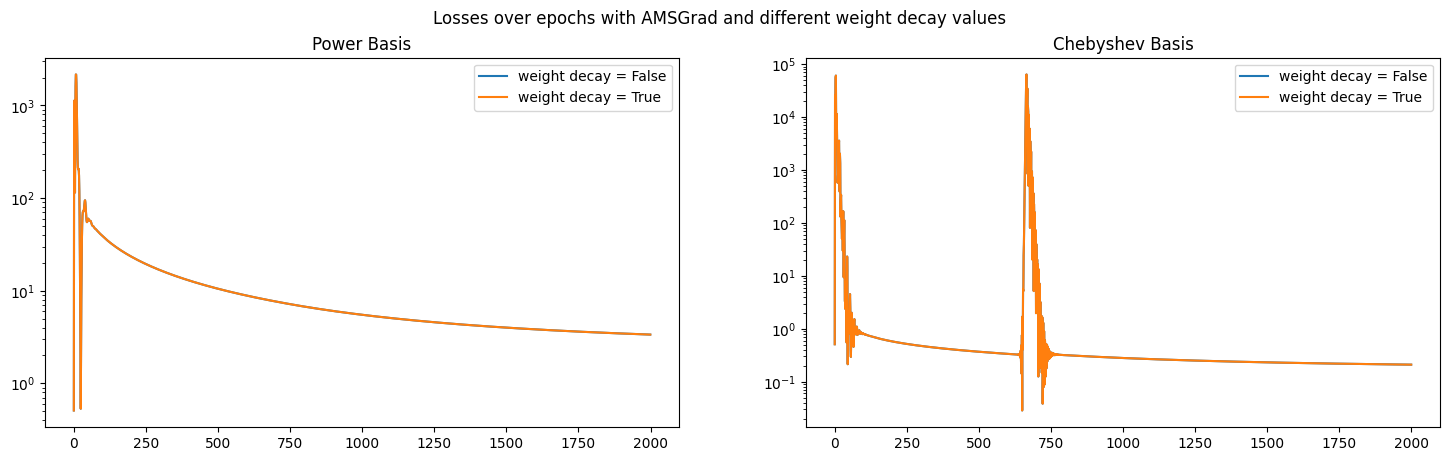

In [129]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.suptitle("Losses over epochs with AMSGrad and different weight decay values")

for i, v in enumerate(vals):
    ax1.semilogy(losses[i], label=f'weight decay = {v}')
    ax2.semilogy(losses_chebyshev[i], label=f'weight decay = {v}')

for ax in (ax1, ax2):
    #ax.set_ylim([1e-10, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")

### Interpretation
**The default is ok for all bases, as no difference can be observed.**

## Ema momentum overwrite frequency with default ema momentum (0.99)

In [130]:
vals = [n*100 for n in range(1, 9)]
vals.insert(0, 1)
vals.insert(0, None)

In [131]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power','learning_rate': learning_rate , 'mode': 'amsgrad-ema_overwrite_frequency',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(vals, repeat(kwargs)))

In [132]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev','learning_rate': learning_rate , 'mode': 'amsgrad-ema_overwrite_frequency',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(vals, repeat(kwargs)))

In [133]:
# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]

Text(0.5, 1.0, 'Chebyshev Basis')

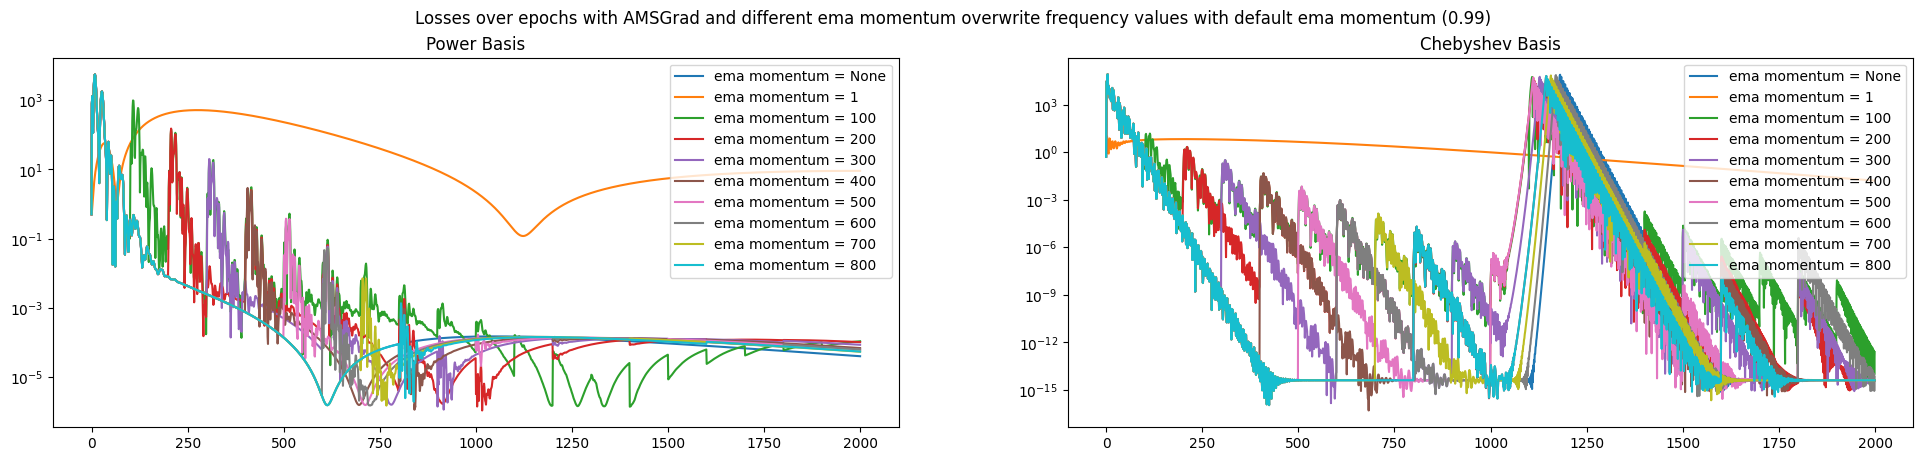

In [134]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(24)
fig.suptitle("Losses over epochs with AMSGrad and different ema momentum overwrite frequency values with default ema momentum (0.99)")

for i, v in enumerate(vals):
    ax1.semilogy(losses[i], label=f'ema momentum = {v}')
    ax2.semilogy(losses_chebyshev[i], label=f'ema momentum = {v}')

for ax in (ax1, ax2):
    #ax.set_ylim([1e-10, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")

### Interpretation

Convergence does not seem to benefit from ema momentum.

## Comparison to $l_2$ baseline

We compare our results to a segment-wise l2-fit (along with resulting C^k errors).

In [148]:
# We increase alpha with rising variance as this requires more emphasis on continuity optimization
lambdas = [0.1, 0.4, 0.9]
args = [(ys2gauss[i], lambdas[i]) for i in range(len(lambdas))]
epochs = 1000
no_segments = 4

In [136]:
kwargs = {'data_x': xsinvar, 'data_y': ysinvar, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 
        'basis': 'power', 'learning_rate': learning_rate, 'mode': 'data_y_and_lambda',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

kwargs = {'data_x': xsinvar, 'data_y': ysinvar, 'polynum': no_segments, 'ck': ck, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs,
        'basis': 'chebyshev', 'learning_rate': learning_rate, 'mode': 'data_y_and_lambda',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xsinvar, ys2gauss[i], basis='power', ck=ck, total_loss_values=results[i][1], D_loss_values=results[i][3])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xsinvar, ys2gauss[i], basis='chebyshev', ck=ck, total_loss_values=results_chebyshev[i][1], D_loss_values=results_chebyshev[i][3])

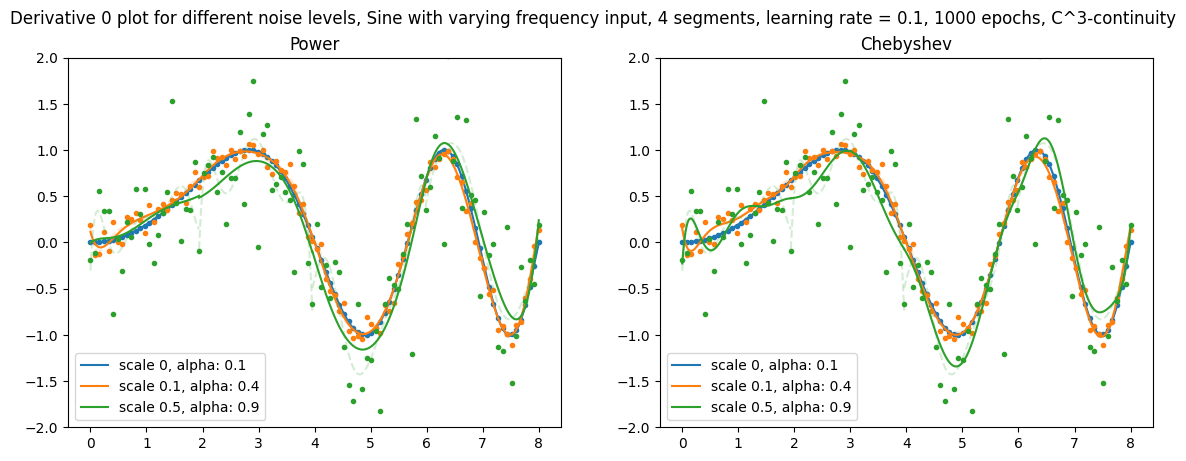

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle(f'Derivative 0 plot for different noise levels, Sine with varying frequency input, {no_segments} segments, learning rate = {learning_rate}, {epochs} epochs, C^{ck}-continuity')
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

optloss = [0.0] * len(splines)

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ysg = ys2gauss[i]
    scale = ys2gauss_scales[i]

    plot.plot_spline(splines[i], label=f'scale {scale:.2g}, alpha: {lambdas[i]}', segment_coloring=False, color=col, ax=ax1, plot_input=False)
    plot.plot_l2optimum(splines[i], deriv=0, color=col, plot_input=True, ax=ax1)
    plot.plot_l2optimum(splines[i], deriv=0, color=col, plot_input=True, ax=ax2)
    plot.plot_spline(splines_chebyshev[i], label=f'scale {scale:.2g}, alpha: {lambdas[i]}', segment_coloring=False, color=col, ax=ax2, plot_input=False)
    #optloss_power[i] = plot.plot_l2optimum(splines[i], lambd=lambdas[i], color=col, plot_input=True, ax=ax1)
    opt = plot.get_l2_baseline_error(splines[i], ck_loss = True, ck = ck)
    optloss[i] = opt[0]+opt[1]

ax1.set_title("Power")
ax1.set_ylim([-2.0, 2])
ax2.set_title("Chebyshev")
ax2.set_ylim([-2.0, 2])
ax1.legend(loc="lower left")
ax2.legend(loc="lower left")

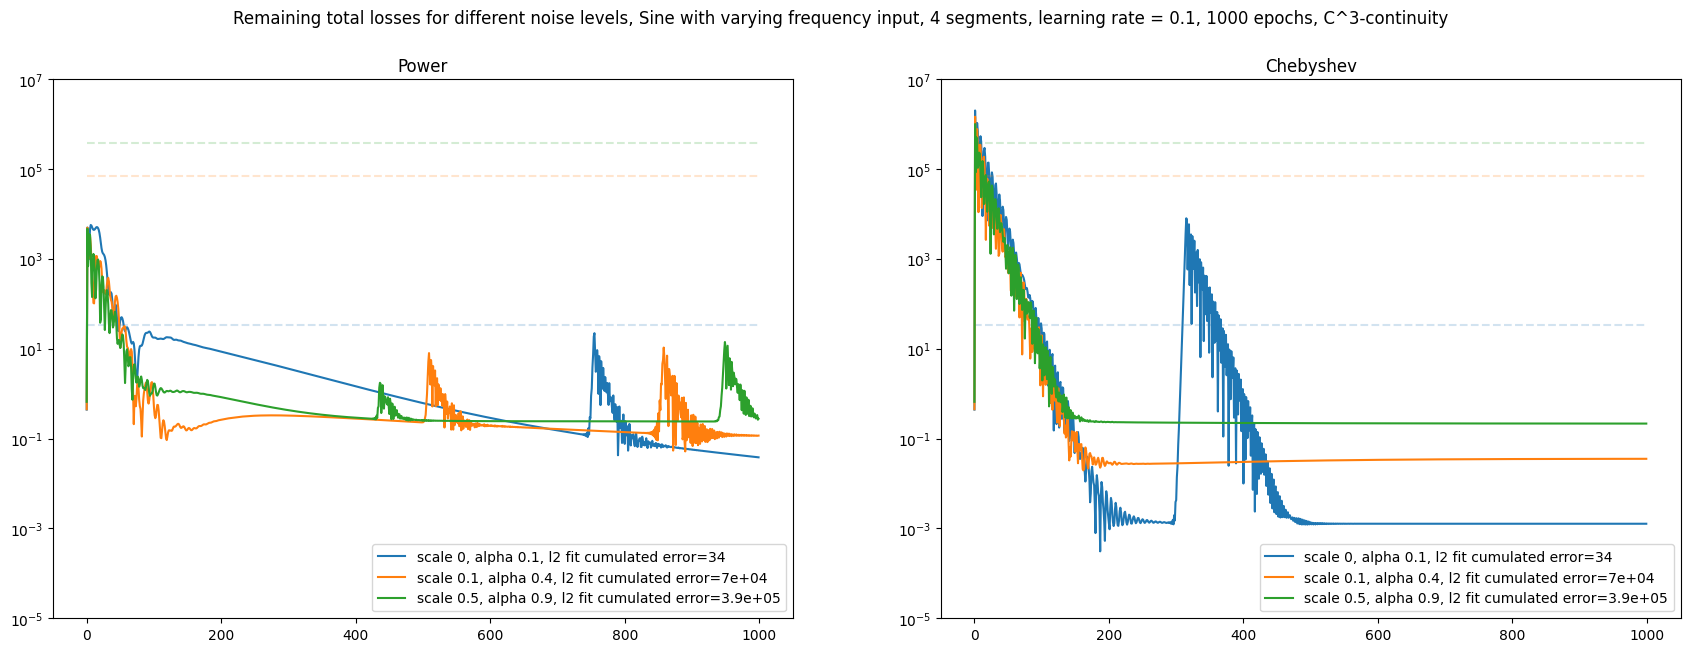

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.suptitle(f'Remaining total losses for different noise levels, Sine with varying frequency input, {no_segments} segments, learning rate = {learning_rate}, {epochs} epochs, C^{ck}-continuity')
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ysg = ys2gauss[i]
    scale = ys2gauss_scales[i]

    ax1.semilogy(splines[i].total_loss_values, label=f'scale {scale:.2g}, alpha {lambdas[i]}, l2 fit cumulated error={optloss[i]:.2g}', c=col)
    ax1.hlines(optloss[i], xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  
    
    ax2.semilogy(splines_chebyshev[i].total_loss_values, label=f'scale {scale:.2g}, alpha {lambdas[i]}, l2 fit cumulated error={optloss[i]:.2g}', c=col)
    ax2.hlines(optloss[i], xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Power")
ax1.set_ylim([1e-5, 1e7])
ax2.set_title("Chebyshev")
ax2.set_ylim([1e-5, 1e7])
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

### Interpretation

As seen earlier, Chebyshev is clearly outperforming Power Basis with less noisy data.
The more variance is in the input data, the closer results for both bases get.
However, Chebyshev basis is performing better also there.